In [1]:
!pip install -q transformers datasets bitsandbytes peft accelerate 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 5.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
bigframes 1

# Label To Text Description

In [2]:
import pandas as pd
import os

def create_descriptive_labels(input_csv_path, output_csv_path):
    """
    Convert binary labels to descriptive text for VLM/MLLM training
    
    Args:
        input_csv_path: Path to the original label.csv with binary values
        output_csv_path: Path to save the new CSV with text descriptions
    """
    # Read the original labels file
    df = pd.read_csv(input_csv_path)
    
    # Component names in a more natural order for text generation
    components = [
        "front left door",
        "front right door", 
        "rear left door", 
        "rear right door", 
        "hood"
    ]
    
    # Column names in the original CSV
    column_names = [
        "front_left_door",
        "front_right_door",
        "rear_left_door",
        "rear_right_door",
        "hood"
    ]
    
    # Create a new dataframe for the text labels
    text_df = pd.DataFrame()
    text_df['filename'] = df['filename']
    text_df['text_description'] = ""
    
    # Process each row
    for idx, row in df.iterrows():
        # Get the status of each component (0=Closed, 1=Open)
        statuses = [int(row[col]) for col in column_names]
        
        # Identify which components are open and which are closed
        open_components = [components[i] for i in range(len(components)) if statuses[i] == 1]
        closed_components = [components[i] for i in range(len(components)) if statuses[i] == 0]
        
        # Generate the descriptive text
        if len(open_components) == 0:
            # All components are closed
            description = "All doors and the hood of the car are closed."
        elif len(closed_components) == 0:
            # All components are open
            description = "All doors and the hood of the car are open."
        else:
            # Some components are open, some are closed
            if len(open_components) == 1:
                open_text = f"The car's {open_components[0]} is open."
            elif len(open_components) == 2:
                open_text = f"The car's {open_components[0]} and {open_components[1]} are open."
            else:
                # For 3 or more components, use comma formatting with "and" before the last item
                open_list = ", ".join(open_components[:-1]) + f", and {open_components[-1]}"
                open_text = f"The car's {open_list} are open."
            
            if len(closed_components) == 1:
                closed_text = f"The {closed_components[0]} remains closed."
            elif len(closed_components) == 2:
                closed_text = f"The {closed_components[0]} and {closed_components[1]} remain closed."
            else:
                # For 3 or more components, use comma formatting with "and" before the last item
                closed_list = ", ".join(closed_components[:-1]) + f", and {closed_components[-1]}"
                closed_text = f"The {closed_list} remain closed."
            
            description = f"{open_text} {closed_text}"
        
        # Store the description
        text_df.at[idx, 'text_description'] = description
    
    # Save the new CSV file
    text_df.to_csv(output_csv_path, index=False)
    print(f"Created text description labels at: {output_csv_path}")
    
    # Print a few examples
    print("\nExample Descriptions:")
    for i in range(min(5, len(text_df))):
        print(f"Image: {text_df.iloc[i]['filename']}")
        print(f"Description: {text_df.iloc[i]['text_description']}")
        print()

if __name__ == "__main__":
    # Paths
    dataset_input_path = "/kaggle/input/3dcardata/car_state_dataset_multilabel"  # Update this to your dataset path
    label_output_path = "/kaggle/working/"
    input_csv = os.path.join(dataset_input_path, "labels.csv")
    output_csv = os.path.join(label_output_path, "text_labels.csv")
    
    # Create the text labels
    create_descriptive_labels(input_csv, output_csv)

Created text description labels at: /kaggle/working/text_labels.csv

Example Descriptions:
Image: view00000000_combo00.png
Description: The car's rear left door is open. The front left door, front right door, rear right door, and hood remain closed.

Image: view00000000_combo01.png
Description: The car's front left door, front right door, and rear right door are open. The rear left door and hood remain closed.

Image: view00000000_combo02.png
Description: The car's front left door, front right door, rear right door, and hood are open. The rear left door remains closed.

Image: view00000000_combo03.png
Description: The car's front right door and rear right door are open. The front left door, rear left door, and hood remain closed.

Image: view00000000_combo04.png
Description: The car's front right door is open. The front left door, rear left door, rear right door, and hood remain closed.



# Model Definition

In [3]:
import torch
import torch.nn as nn


class ResidualBlock(nn.Module):
    """Basic residual block for ResNet architecture."""
    
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        
        # First convolution layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
        # Second convolution layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Skip connection (shortcut)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
        # Activation function
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        residual = x
        
        # First conv block
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        # Second conv block
        out = self.conv2(out)
        out = self.bn2(out)
        
        # Add skip connection
        out += self.shortcut(residual)
        out = self.relu(out)
        
        return out
    
class BottleneckBlock(nn.Module):
    """Bottleneck block used in deeper ResNet architectures (50, 101, 152)."""
    
    expansion = 4  # Output channels expand by 4x
    
    def __init__(self, in_channels, out_channels, stride=1):
        super(BottleneckBlock, self).__init__()
        
        # Bottleneck design: reduce dimensions, process, then expand
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        
        self.relu = nn.ReLU(inplace=True)
        
        # Skip connection (shortcut)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * self.expansion)
            )
    
    def forward(self, x):
        residual = x
        
        # First 1x1 conv
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        # 3x3 conv
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        # Second 1x1 conv for expansion
        out = self.conv3(out)
        out = self.bn3(out)
        
        # Add skip connection
        out += self.shortcut(residual)
        out = self.relu(out)
        
        return out


class ResNet(nn.Module):
    """Improved ResNet architecture with support for bottleneck blocks."""
    
    def __init__(self, block, num_blocks):
        super(ResNet, self).__init__()
        
        self.in_channels = 64
        
        # Initial convolution layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # Residual layers
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        
        # Global average pooling
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Initialize weights
        self._initialize_weights()
    
    def _make_layer(self, block, out_channels, num_blocks, stride):
        """Create a layer with multiple residual blocks."""
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            if hasattr(block, 'expansion'):
                self.in_channels = out_channels * block.expansion
            else:
                self.in_channels = out_channels
            
        return nn.Sequential(*layers)
    
    def _initialize_weights(self):
        """Initialize model weights for better convergence."""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Initial convolution
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        # Residual blocks
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        # Global average pooling
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        
        return x


    
class ViewInvariantModel(nn.Module):
    """Model with feature extractor and projection head for contrastive learning."""
    
    def __init__(self, embedding_dim=256, resnet_version=50):
        super(ViewInvariantModel, self).__init__()
        
        # Feature extractor (ResNet-50)
        if resnet_version == 18:
            self.feature_extractor = ResNet(ResidualBlock, [2, 2, 2, 2])  # ResNet-18
        elif resnet_version == 34:
            self.feature_extractor = ResNet(ResidualBlock, [3, 4, 6, 3])  # ResNet-34
        elif resnet_version == 26:
            self.feature_extractor = ResNet(BottleneckBlock, [2, 2, 2, 2])  # ResNet-26
        else:
            self.feature_extractor = ResNet(BottleneckBlock, [3, 4, 6, 3])  # ResNet-50
        
        # Projection head for contrastive learning
        if resnet_version == 18 or resnet_version == 34:
            # Smaller Projection      
            self.projection_head = nn.Sequential(
                nn.Linear(512, 512),
                nn.ReLU(inplace=True),
                nn.Linear(512, embedding_dim)
            )
        else:
            self.projection_head = nn.Sequential(
                nn.Linear(2048, 1024),  # 2048 = 512 * 4 (expansion factor)
                nn.ReLU(inplace=True),
                nn.Linear(1024, embedding_dim)
            )
        

    
    def forward(self, x):
        # Extract features
        features = self.feature_extractor(x)
        
        # Project features for contrastive learning
        projections = self.projection_head(features)
        
        return features, projections
    
class ComponentClassifier(nn.Module):
    """Multi-head classifier built on top of view-invariant feature extractor."""
    
    def __init__(self, embedding_dim, num_components=5):
        super(ComponentClassifier, self).__init__()
        
        # Load pre-trained view-invariant model
        self.base_model = ViewInvariantModel(embedding_dim=embedding_dim)
        
        # Get feature dimension from base model
        # self.feature_dim = 512  # This should match the feature extractor output
        self.feature_dim = 2048  
        
        # Component classification heads (one for each component)
        self.component_heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(self.feature_dim, 128),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(128, 1)
            ) for _ in range(num_components)
        ])
        
    def load_unfreeze_feature_extractor(self, pretrained_extractor_path, freeze_feature_extractor=False):
        # Load pre-trained weights
        checkpoint = torch.load(pretrained_extractor_path)
        self.base_model.load_state_dict(checkpoint['model_state_dict'])
        
        # Freeze feature extractor if specified
        if freeze_feature_extractor:
            for param in self.base_model.feature_extractor.parameters():
                param.requires_grad = False
        
    def forward(self, x, return_features=False):
        # Get features and projections from base model
        features, projections = self.base_model(x)
        
        # Apply component-specific classifiers
        outputs = []
        for head in self.component_heads:
            outputs.append(head(features))
        
        # Stack outputs along dimension 1
        logits = torch.cat(outputs, dim=1)
        
        if return_features:
            return logits, features, projections
        return logits

# Training Phase 1: Modality Projection

Starting Phase 1 training: projection layer integration
Initializing Car-LLaVA Phase 1 model


/tmp/ipykernel_19/3540099285.py:106: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(cnn_model_path)


CNN model loaded and frozen


tokenizer_config.json:   0%|          | 0.00/3.76k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/801k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

Added 2 special tokens to tokenizer


config.json:   0%|          | 0.00/861 [00:00<?, ?B/s]

2025-05-17 17:07:10.014323: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747501630.201725      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747501630.252896      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/269M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


LLM loaded and frozen
Trainable parameters in projection layer: 3,979,200
Loading dataset from /kaggle/working/text_labels.csv
Dataset split: 4320 training, 480 validation samples
Training for 75 epochs, 5062 total steps, 253 warmup steps
Using device: cuda
Using 2 GPUs for training
Starting training loop


Epoch 1/75:   0%|          | 0/270 [00:00<?, ?it/s]

Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1: Train Loss = 3.7522, Val Loss = 3.6467
New best model saved to car_llava_phase1/best_projection_layer.pt with validation loss 3.6467


Epoch 2/75:   0%|          | 0/270 [00:00<?, ?it/s]

Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 2: Train Loss = 3.5730, Val Loss = 3.5248
New best model saved to car_llava_phase1/best_projection_layer.pt with validation loss 3.5248


Epoch 3/75:   0%|          | 0/270 [00:00<?, ?it/s]

Saved checkpoint at step 200 to car_llava_phase1/checkpoint-step-200.pt
Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 3: Train Loss = 3.4955, Val Loss = 3.4908
New best model saved to car_llava_phase1/best_projection_layer.pt with validation loss 3.4908


Epoch 4/75:   0%|          | 0/270 [00:00<?, ?it/s]

Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 4: Train Loss = 3.4694, Val Loss = 3.4556
New best model saved to car_llava_phase1/best_projection_layer.pt with validation loss 3.4556


Epoch 5/75:   0%|          | 0/270 [00:00<?, ?it/s]

Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 5: Train Loss = 3.4382, Val Loss = 3.4224
New best model saved to car_llava_phase1/best_projection_layer.pt with validation loss 3.4224


Epoch 6/75:   0%|          | 0/270 [00:00<?, ?it/s]

Saved checkpoint at step 400 to car_llava_phase1/checkpoint-step-400.pt
Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 6: Train Loss = 3.4155, Val Loss = 3.4096
New best model saved to car_llava_phase1/best_projection_layer.pt with validation loss 3.4096


Epoch 7/75:   0%|          | 0/270 [00:00<?, ?it/s]

Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 7: Train Loss = 3.3954, Val Loss = 3.3884
New best model saved to car_llava_phase1/best_projection_layer.pt with validation loss 3.3884


Epoch 8/75:   0%|          | 0/270 [00:00<?, ?it/s]

Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 8: Train Loss = 3.3724, Val Loss = 3.3775
New best model saved to car_llava_phase1/best_projection_layer.pt with validation loss 3.3775


Epoch 9/75:   0%|          | 0/270 [00:00<?, ?it/s]

Saved checkpoint at step 600 to car_llava_phase1/checkpoint-step-600.pt
Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 9: Train Loss = 3.3556, Val Loss = 3.3579
New best model saved to car_llava_phase1/best_projection_layer.pt with validation loss 3.3579


Epoch 10/75:   0%|          | 0/270 [00:00<?, ?it/s]

Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 10: Train Loss = 3.3448, Val Loss = 3.3264
New best model saved to car_llava_phase1/best_projection_layer.pt with validation loss 3.3264


Epoch 11/75:   0%|          | 0/270 [00:00<?, ?it/s]

Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 11: Train Loss = 3.3317, Val Loss = 3.3240
New best model saved to car_llava_phase1/best_projection_layer.pt with validation loss 3.3240


Epoch 12/75:   0%|          | 0/270 [00:00<?, ?it/s]

Saved checkpoint at step 800 to car_llava_phase1/checkpoint-step-800.pt
Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 12: Train Loss = 3.3241, Val Loss = 3.3314


Epoch 13/75:   0%|          | 0/270 [00:00<?, ?it/s]

Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 13: Train Loss = 3.3163, Val Loss = 3.3107
New best model saved to car_llava_phase1/best_projection_layer.pt with validation loss 3.3107


Epoch 14/75:   0%|          | 0/270 [00:00<?, ?it/s]

Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 14: Train Loss = 3.3052, Val Loss = 3.3074
New best model saved to car_llava_phase1/best_projection_layer.pt with validation loss 3.3074


Epoch 15/75:   0%|          | 0/270 [00:00<?, ?it/s]

Saved checkpoint at step 1000 to car_llava_phase1/checkpoint-step-1000.pt
Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 15: Train Loss = 3.3062, Val Loss = 3.3072
New best model saved to car_llava_phase1/best_projection_layer.pt with validation loss 3.3072


Epoch 16/75:   0%|          | 0/270 [00:00<?, ?it/s]

Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 16: Train Loss = 3.2954, Val Loss = 3.2954
New best model saved to car_llava_phase1/best_projection_layer.pt with validation loss 3.2954


Epoch 17/75:   0%|          | 0/270 [00:00<?, ?it/s]

Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 17: Train Loss = 3.2895, Val Loss = 3.2895
New best model saved to car_llava_phase1/best_projection_layer.pt with validation loss 3.2895


Epoch 18/75:   0%|          | 0/270 [00:00<?, ?it/s]

Saved checkpoint at step 1200 to car_llava_phase1/checkpoint-step-1200.pt
Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 18: Train Loss = 3.2843, Val Loss = 3.2699
New best model saved to car_llava_phase1/best_projection_layer.pt with validation loss 3.2699


Epoch 19/75:   0%|          | 0/270 [00:00<?, ?it/s]

Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 19: Train Loss = 3.2768, Val Loss = 3.2867


Epoch 20/75:   0%|          | 0/270 [00:00<?, ?it/s]

Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 20: Train Loss = 3.2758, Val Loss = 3.2758


Epoch 21/75:   0%|          | 0/270 [00:00<?, ?it/s]

Saved checkpoint at step 1400 to car_llava_phase1/checkpoint-step-1400.pt
Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 21: Train Loss = 3.2673, Val Loss = 3.2648
New best model saved to car_llava_phase1/best_projection_layer.pt with validation loss 3.2648


Epoch 22/75:   0%|          | 0/270 [00:00<?, ?it/s]

Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 22: Train Loss = 3.2610, Val Loss = 3.2642
New best model saved to car_llava_phase1/best_projection_layer.pt with validation loss 3.2642


Epoch 23/75:   0%|          | 0/270 [00:00<?, ?it/s]

Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 23: Train Loss = 3.2600, Val Loss = 3.2616
New best model saved to car_llava_phase1/best_projection_layer.pt with validation loss 3.2616


Epoch 24/75:   0%|          | 0/270 [00:00<?, ?it/s]

Saved checkpoint at step 1600 to car_llava_phase1/checkpoint-step-1600.pt
Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 24: Train Loss = 3.2573, Val Loss = 3.2656


Epoch 25/75:   0%|          | 0/270 [00:00<?, ?it/s]

Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 25: Train Loss = 3.2484, Val Loss = 3.2452
New best model saved to car_llava_phase1/best_projection_layer.pt with validation loss 3.2452


Epoch 26/75:   0%|          | 0/270 [00:00<?, ?it/s]

Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 26: Train Loss = 3.2481, Val Loss = 3.2469


Epoch 27/75:   0%|          | 0/270 [00:00<?, ?it/s]

Saved checkpoint at step 1800 to car_llava_phase1/checkpoint-step-1800.pt
Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 27: Train Loss = 3.2379, Val Loss = 3.2399
New best model saved to car_llava_phase1/best_projection_layer.pt with validation loss 3.2399


Epoch 28/75:   0%|          | 0/270 [00:00<?, ?it/s]

Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 28: Train Loss = 3.2403, Val Loss = 3.2309
New best model saved to car_llava_phase1/best_projection_layer.pt with validation loss 3.2309


Epoch 29/75:   0%|          | 0/270 [00:00<?, ?it/s]

Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 29: Train Loss = 3.2354, Val Loss = 3.2334


Epoch 30/75:   0%|          | 0/270 [00:00<?, ?it/s]

Saved checkpoint at step 2000 to car_llava_phase1/checkpoint-step-2000.pt
Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 30: Train Loss = 3.2306, Val Loss = 3.2332


Epoch 31/75:   0%|          | 0/270 [00:00<?, ?it/s]

Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 31: Train Loss = 3.2288, Val Loss = 3.2353


Epoch 32/75:   0%|          | 0/270 [00:00<?, ?it/s]

Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 32: Train Loss = 3.2217, Val Loss = 3.2222
New best model saved to car_llava_phase1/best_projection_layer.pt with validation loss 3.2222


Epoch 33/75:   0%|          | 0/270 [00:00<?, ?it/s]

Saved checkpoint at step 2200 to car_llava_phase1/checkpoint-step-2200.pt
Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 33: Train Loss = 3.2190, Val Loss = 3.2157
New best model saved to car_llava_phase1/best_projection_layer.pt with validation loss 3.2157


Epoch 34/75:   0%|          | 0/270 [00:00<?, ?it/s]

Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 34: Train Loss = 3.2166, Val Loss = 3.2201


Epoch 35/75:   0%|          | 0/270 [00:00<?, ?it/s]

Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 35: Train Loss = 3.2126, Val Loss = 3.2105
New best model saved to car_llava_phase1/best_projection_layer.pt with validation loss 3.2105


Epoch 36/75:   0%|          | 0/270 [00:00<?, ?it/s]

Saved checkpoint at step 2400 to car_llava_phase1/checkpoint-step-2400.pt
Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 36: Train Loss = 3.2051, Val Loss = 3.2153


Epoch 37/75:   0%|          | 0/270 [00:00<?, ?it/s]

Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 37: Train Loss = 3.2058, Val Loss = 3.2108


Epoch 38/75:   0%|          | 0/270 [00:00<?, ?it/s]

Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 38: Train Loss = 3.2018, Val Loss = 3.1990
New best model saved to car_llava_phase1/best_projection_layer.pt with validation loss 3.1990


Epoch 39/75:   0%|          | 0/270 [00:00<?, ?it/s]

Saved checkpoint at step 2600 to car_llava_phase1/checkpoint-step-2600.pt
Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 39: Train Loss = 3.1978, Val Loss = 3.1962
New best model saved to car_llava_phase1/best_projection_layer.pt with validation loss 3.1962


Epoch 40/75:   0%|          | 0/270 [00:00<?, ?it/s]

Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 40: Train Loss = 3.1997, Val Loss = 3.1956
New best model saved to car_llava_phase1/best_projection_layer.pt with validation loss 3.1956


Epoch 41/75:   0%|          | 0/270 [00:00<?, ?it/s]

Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 41: Train Loss = 3.1920, Val Loss = 3.1935
New best model saved to car_llava_phase1/best_projection_layer.pt with validation loss 3.1935


Epoch 42/75:   0%|          | 0/270 [00:00<?, ?it/s]

Saved checkpoint at step 2800 to car_llava_phase1/checkpoint-step-2800.pt
Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 42: Train Loss = 3.1904, Val Loss = 3.1969


Epoch 43/75:   0%|          | 0/270 [00:00<?, ?it/s]

Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 43: Train Loss = 3.1891, Val Loss = 3.1868
New best model saved to car_llava_phase1/best_projection_layer.pt with validation loss 3.1868


Epoch 44/75:   0%|          | 0/270 [00:00<?, ?it/s]

Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 44: Train Loss = 3.1864, Val Loss = 3.1949


Epoch 45/75:   0%|          | 0/270 [00:00<?, ?it/s]

Saved checkpoint at step 3000 to car_llava_phase1/checkpoint-step-3000.pt
Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 45: Train Loss = 3.1834, Val Loss = 3.1796
New best model saved to car_llava_phase1/best_projection_layer.pt with validation loss 3.1796


Epoch 46/75:   0%|          | 0/270 [00:00<?, ?it/s]

Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 46: Train Loss = 3.1807, Val Loss = 3.1781
New best model saved to car_llava_phase1/best_projection_layer.pt with validation loss 3.1781


Epoch 47/75:   0%|          | 0/270 [00:00<?, ?it/s]

Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 47: Train Loss = 3.1791, Val Loss = 3.1845


Epoch 48/75:   0%|          | 0/270 [00:00<?, ?it/s]

Saved checkpoint at step 3200 to car_llava_phase1/checkpoint-step-3200.pt
Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 48: Train Loss = 3.1758, Val Loss = 3.1834


Epoch 49/75:   0%|          | 0/270 [00:00<?, ?it/s]

Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 49: Train Loss = 3.1728, Val Loss = 3.1752
New best model saved to car_llava_phase1/best_projection_layer.pt with validation loss 3.1752


Epoch 50/75:   0%|          | 0/270 [00:00<?, ?it/s]

Saved checkpoint at step 3400 to car_llava_phase1/checkpoint-step-3400.pt
Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 50: Train Loss = 3.1718, Val Loss = 3.1716
New best model saved to car_llava_phase1/best_projection_layer.pt with validation loss 3.1716


Epoch 51/75:   0%|          | 0/270 [00:00<?, ?it/s]

Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 51: Train Loss = 3.1700, Val Loss = 3.1757


Epoch 52/75:   0%|          | 0/270 [00:00<?, ?it/s]

Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 52: Train Loss = 3.1671, Val Loss = 3.1699
New best model saved to car_llava_phase1/best_projection_layer.pt with validation loss 3.1699


Epoch 53/75:   0%|          | 0/270 [00:00<?, ?it/s]

Saved checkpoint at step 3600 to car_llava_phase1/checkpoint-step-3600.pt
Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 53: Train Loss = 3.1652, Val Loss = 3.1661
New best model saved to car_llava_phase1/best_projection_layer.pt with validation loss 3.1661


Epoch 54/75:   0%|          | 0/270 [00:00<?, ?it/s]

Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 54: Train Loss = 3.1636, Val Loss = 3.1637
New best model saved to car_llava_phase1/best_projection_layer.pt with validation loss 3.1637


Epoch 55/75:   0%|          | 0/270 [00:00<?, ?it/s]

Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 55: Train Loss = 3.1621, Val Loss = 3.1660


Epoch 56/75:   0%|          | 0/270 [00:00<?, ?it/s]

Saved checkpoint at step 3800 to car_llava_phase1/checkpoint-step-3800.pt
Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 56: Train Loss = 3.1612, Val Loss = 3.1603
New best model saved to car_llava_phase1/best_projection_layer.pt with validation loss 3.1603


Epoch 57/75:   0%|          | 0/270 [00:00<?, ?it/s]

Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 57: Train Loss = 3.1586, Val Loss = 3.1614


Epoch 58/75:   0%|          | 0/270 [00:00<?, ?it/s]

Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 58: Train Loss = 3.1580, Val Loss = 3.1592
New best model saved to car_llava_phase1/best_projection_layer.pt with validation loss 3.1592


Epoch 59/75:   0%|          | 0/270 [00:00<?, ?it/s]

Saved checkpoint at step 4000 to car_llava_phase1/checkpoint-step-4000.pt
Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 59: Train Loss = 3.1547, Val Loss = 3.1588
New best model saved to car_llava_phase1/best_projection_layer.pt with validation loss 3.1588


Epoch 60/75:   0%|          | 0/270 [00:00<?, ?it/s]

Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 60: Train Loss = 3.1541, Val Loss = 3.1575
New best model saved to car_llava_phase1/best_projection_layer.pt with validation loss 3.1575


Epoch 61/75:   0%|          | 0/270 [00:00<?, ?it/s]

Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 61: Train Loss = 3.1518, Val Loss = 3.1552
New best model saved to car_llava_phase1/best_projection_layer.pt with validation loss 3.1552


Epoch 62/75:   0%|          | 0/270 [00:00<?, ?it/s]

Saved checkpoint at step 4200 to car_llava_phase1/checkpoint-step-4200.pt
Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 62: Train Loss = 3.1512, Val Loss = 3.1518
New best model saved to car_llava_phase1/best_projection_layer.pt with validation loss 3.1518


Epoch 63/75:   0%|          | 0/270 [00:00<?, ?it/s]

Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 63: Train Loss = 3.1497, Val Loss = 3.1523


Epoch 64/75:   0%|          | 0/270 [00:00<?, ?it/s]

Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 64: Train Loss = 3.1481, Val Loss = 3.1505
New best model saved to car_llava_phase1/best_projection_layer.pt with validation loss 3.1505


Epoch 65/75:   0%|          | 0/270 [00:00<?, ?it/s]

Saved checkpoint at step 4400 to car_llava_phase1/checkpoint-step-4400.pt
Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 65: Train Loss = 3.1468, Val Loss = 3.1490
New best model saved to car_llava_phase1/best_projection_layer.pt with validation loss 3.1490


Epoch 66/75:   0%|          | 0/270 [00:00<?, ?it/s]

Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 66: Train Loss = 3.1456, Val Loss = 3.1484
New best model saved to car_llava_phase1/best_projection_layer.pt with validation loss 3.1484


Epoch 67/75:   0%|          | 0/270 [00:00<?, ?it/s]

Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 67: Train Loss = 3.1445, Val Loss = 3.1480
New best model saved to car_llava_phase1/best_projection_layer.pt with validation loss 3.1480


Epoch 68/75:   0%|          | 0/270 [00:00<?, ?it/s]

Saved checkpoint at step 4600 to car_llava_phase1/checkpoint-step-4600.pt
Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 68: Train Loss = 3.1438, Val Loss = 3.1474
New best model saved to car_llava_phase1/best_projection_layer.pt with validation loss 3.1474


Epoch 69/75:   0%|          | 0/270 [00:00<?, ?it/s]

Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 69: Train Loss = 3.1429, Val Loss = 3.1458
New best model saved to car_llava_phase1/best_projection_layer.pt with validation loss 3.1458


Epoch 70/75:   0%|          | 0/270 [00:00<?, ?it/s]

Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 70: Train Loss = 3.1418, Val Loss = 3.1447
New best model saved to car_llava_phase1/best_projection_layer.pt with validation loss 3.1447


Epoch 71/75:   0%|          | 0/270 [00:00<?, ?it/s]

Saved checkpoint at step 4800 to car_llava_phase1/checkpoint-step-4800.pt
Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 71: Train Loss = 3.1409, Val Loss = 3.1445
New best model saved to car_llava_phase1/best_projection_layer.pt with validation loss 3.1445


Epoch 72/75:   0%|          | 0/270 [00:00<?, ?it/s]

Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 72: Train Loss = 3.1402, Val Loss = 3.1436
New best model saved to car_llava_phase1/best_projection_layer.pt with validation loss 3.1436


Epoch 73/75:   0%|          | 0/270 [00:00<?, ?it/s]

Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 73: Train Loss = 3.1395, Val Loss = 3.1430
New best model saved to car_llava_phase1/best_projection_layer.pt with validation loss 3.1430


Epoch 74/75:   0%|          | 0/270 [00:00<?, ?it/s]

Saved checkpoint at step 5000 to car_llava_phase1/checkpoint-step-5000.pt
Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 74: Train Loss = 3.1391, Val Loss = 3.1425
New best model saved to car_llava_phase1/best_projection_layer.pt with validation loss 3.1425


Epoch 75/75:   0%|          | 0/270 [00:00<?, ?it/s]

Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 75: Train Loss = 3.1387, Val Loss = 3.1425
New best model saved to car_llava_phase1/best_projection_layer.pt with validation loss 3.1425
Final model saved to car_llava_phase1/final_projection_layer.pt
Phase 1 training complete!


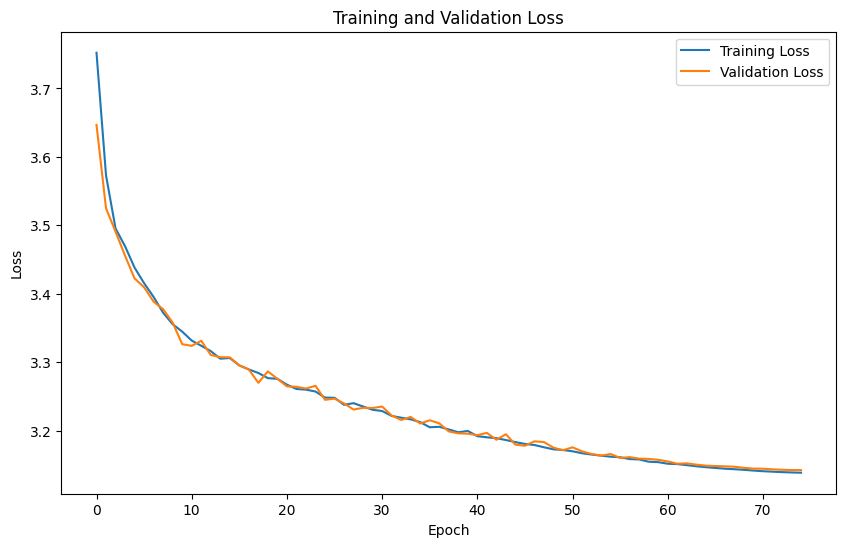

In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import get_linear_schedule_with_warmup
from PIL import Image
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt


# Configuration
CONFIG = {
    "dataset_path": "/kaggle/input/3dcardata/car_state_dataset_multilabel",
    "text_labels_path": "/kaggle/working/text_labels.csv",
    "cnn_model_path": "/kaggle/input/car_component_classifier/pytorch/default/1/car_component_classifier_model_resnet50_max.pt",
    "llm_model_path": "HuggingFaceTB/SmolLM2-135M-Instruct",
    "output_dir": "car_llava_phase1",
    "batch_size": 16,  # Can be larger with the smaller model
    "gradient_accumulation_steps": 4,  # Effective batch size = 64
    "epochs": 75,  # Can train longer with the smaller model
    "learning_rate": 1e-4,  # Higher learning rate for projection layer only
    "warmup_ratio": 0.05,
    "max_length": 256,  # Can be smaller for this task
    "image_size": 224,
    "feature_dim": 2048,     # CNN feature dimension
    "classifier_dim": 5,    # Number of car components
    "hidden_dim": 768,      # Projection hidden dimension
    "llm_embedding_dim": 576,  # SmolLM2 embedding dimension
    "save_every_steps": 200
}

# Ensure output directory exists
os.makedirs(CONFIG["output_dir"], exist_ok=True)

class VisionProjectionLayer(nn.Module):
    """Projects visual features from CNN to the LLM embedding space"""
    
    def __init__(self, 
                 vision_feature_dim=2048,     # CNN feature dimension
                 vision_classifier_dim=5,     # Number of components 
                 llm_embedding_dim=576,       # SmolLM2 embedding dimension
                 hidden_dim=768):             # Projection hidden dimension
        super().__init__()
        
        # Feature projection path - added an extra layer
        self.feature_projection = nn.Sequential(
            nn.Linear(vision_feature_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),  # Added layer
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, llm_embedding_dim)
        )
        
        # Classification result projection path
        self.classifier_projection = nn.Sequential(
            nn.Linear(vision_classifier_dim, hidden_dim // 4),
            nn.LayerNorm(hidden_dim // 4),
            nn.GELU(),
            nn.Linear(hidden_dim // 4, llm_embedding_dim)
        )
        
        # Combined attention pooling
        self.attention_pool = nn.Sequential(
            nn.Linear(llm_embedding_dim * 2, llm_embedding_dim),
            nn.Tanh()
        )
        
    def forward(self, features, classifier_outputs):
        # Project features and classifier outputs
        feature_embedding = self.feature_projection(features)
        classifier_embedding = self.classifier_projection(classifier_outputs)
        
        # Combine projections
        combined = torch.cat([feature_embedding, classifier_embedding], dim=1)
        visual_embedding = self.attention_pool(combined)
        
        return visual_embedding



class CarLLaVA_Phase1(nn.Module):
    """
    Phase 1 of Car-LLaVA model: CNN and LLM are frozen, only train projection layer
    """
    
    def __init__(self, 
                 cnn_model_path,              # Path to fine-tuned car component model
                 llm_model_path,              # Path to LLM
                 projection_hidden_dim=512,   # Hidden dim for projection layer
                 vision_feature_dim=512,      # CNN feature dimension
                 vision_classifier_dim=5,     # Number of components
                 llm_embedding_dim=576):      # SmolLM2 embedding dimension
        super().__init__()
        
        # Load CNN classifier model (includes both feature extractor and classifier)
        self.vision_model = ComponentClassifier(embedding_dim=256)
        checkpoint = torch.load(cnn_model_path)
        self.vision_model.load_state_dict(checkpoint['model_state_dict'])
        
        # Freeze CNN
        for param in self.vision_model.parameters():
            param.requires_grad = False
        print("CNN model loaded and frozen")
        
        # Load tokenizer and add special tokens
        self.tokenizer = AutoTokenizer.from_pretrained(llm_model_path)
        special_tokens = {"additional_special_tokens": ["<image>", "</image>"]}
        num_added = self.tokenizer.add_special_tokens(special_tokens)
        print(f"Added {num_added} special tokens to tokenizer")
        
        # Load LLM 
        self.llm = AutoModelForCausalLM.from_pretrained(llm_model_path)
        
        # Resize token embeddings to account for new special tokens
        self.llm.resize_token_embeddings(len(self.tokenizer))
        
        # Freeze LLM
        for param in self.llm.parameters():
            param.requires_grad = False
        print("LLM loaded and frozen")
        
        # Create projection layer (the only trainable part in phase 1)
        self.projection_layer = VisionProjectionLayer(
            vision_feature_dim=vision_feature_dim,
            vision_classifier_dim=vision_classifier_dim,
            llm_embedding_dim=llm_embedding_dim,
            hidden_dim=projection_hidden_dim
        )
        
        # Log trainable parameters
        trainable_params = sum(p.numel() for p in self.projection_layer.parameters() if p.requires_grad)
        print(f"Trainable parameters in projection layer: {trainable_params:,}")
    
    def forward(self, images, input_ids, attention_mask=None):
        # Process images through CNN (with gradients disabled)
        with torch.no_grad():
            self.vision_model.eval()
            logits, features, _ = self.vision_model(images, return_features=True)
            sigmoid_outputs = torch.sigmoid(logits)
        
        # Project visual features to LLM embedding space (this has gradients)
        visual_embedding = self.projection_layer(features, sigmoid_outputs)
        
        # Get LLM input embeddings (detached - we don't want to train the embedding table)
        embedding_layer = self.llm.get_input_embeddings()
        llm_inputs = embedding_layer(input_ids).detach()
        
        # Find positions of image tokens
        batch_size = input_ids.shape[0]
        image_token_id = self.tokenizer.convert_tokens_to_ids("<image>")
        
        # Replace <image> token embeddings with visual embeddings
        for b in range(batch_size):
            image_positions = (input_ids[b] == image_token_id).nonzero(as_tuple=True)[0]
            if len(image_positions) > 0:
                image_pos = image_positions[0]
                # Important: This connects our projection layer to the computation graph
                llm_inputs[b, image_pos] = visual_embedding[b]
        
        # Forward pass through LLM - WITHOUT using torch.no_grad()
        # Parameters are still frozen (requires_grad=False) but gradients can flow through
        outputs = self.llm(
            inputs_embeds=llm_inputs,
            attention_mask=attention_mask,
            return_dict=True
        )
        
        return outputs


class CarLLaVADataset(Dataset):
    """Dataset for training LLaVA-style car component model"""
    
    def __init__(self, 
                 image_dir, 
                 text_labels_path, 
                 tokenizer, 
                 transform=None,
                 max_length=256):
        self.image_dir = image_dir
        self.text_df = pd.read_csv(text_labels_path)
        self.tokenizer = tokenizer
        self.transform = transform
        self.max_length = max_length
        
    def __len__(self):
        return len(self.text_df)
    
    def __getitem__(self, idx):
        # Get image and text description
        img_name = self.text_df.iloc[idx]['filename']
        description = self.text_df.iloc[idx]['text_description']
        
        # Load and transform image
        img_path = os.path.join(self.image_dir, "images", img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        # Create chat messages for SmolLM2
        messages = [
            {"role": "user", "content": "Examine this car image and describe which doors and hood are open or closed.\n<image></image>"},
            {"role": "assistant", "content": description}
        ]
        
        # Use the model's chat template to format the messages
        input_text = self.tokenizer.apply_chat_template(messages, tokenize=False)
        
        # Tokenize
        encodings = self.tokenizer(
            input_text,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=self.max_length
        )
        
        input_ids = encodings.input_ids.squeeze(0)
        attention_mask = encodings.attention_mask.squeeze(0)
        
        # Create labels for autoregressive training
        labels = input_ids.clone()
        
        # Set -100 (ignore index) for all tokens from the user message
        # Find the first assistant message token index
        assistant_idx = input_text.find("assistant")
        if assistant_idx != -1:
            # Find the token position approximately
            assistant_enc = self.tokenizer.encode(input_text[:assistant_idx], add_special_tokens=False)
            # Set all tokens before assistant response to -100
            labels[:len(assistant_enc)] = -100
            
        # Also set -100 for padding tokens
        labels[labels == self.tokenizer.pad_token_id] = -100
        
        return {
            "image": image,
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels
        }



def train_phase1():
    """Train Phase 1 of Car-LLaVA: projection layer only"""
    
    print("Starting Phase 1 training: projection layer integration")
    
    # Set up data transforms
    transform = transforms.Compose([
        transforms.Resize((CONFIG["image_size"], CONFIG["image_size"])),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Initialize model
    print("Initializing Car-LLaVA Phase 1 model")
    model = CarLLaVA_Phase1(
        cnn_model_path=CONFIG["cnn_model_path"],
        llm_model_path=CONFIG["llm_model_path"],
        projection_hidden_dim=CONFIG["hidden_dim"],
        vision_feature_dim=CONFIG["feature_dim"],
        vision_classifier_dim=CONFIG["classifier_dim"],
        llm_embedding_dim=CONFIG["llm_embedding_dim"]
    )
    
    # Create dataset
    print(f"Loading dataset from {CONFIG['text_labels_path']}")
    dataset = CarLLaVADataset(
        image_dir=CONFIG["dataset_path"],
        text_labels_path=CONFIG["text_labels_path"],
        tokenizer=model.tokenizer,
        transform=transform,
        max_length=CONFIG["max_length"]
    )
    
    # Split dataset
    train_size = int(0.9 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    print(f"Dataset split: {train_size} training, {val_size} validation samples")
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=CONFIG["batch_size"],
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        persistent_workers=True,
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=CONFIG["batch_size"],
        shuffle=False,
        num_workers=4,
        pin_memory=True,
        persistent_workers=True,
    )
    
    # Set up optimizer - only optimize projection layer parameters
    optimizer = optim.AdamW(
        model.projection_layer.parameters(),
        lr=CONFIG["learning_rate"],
        weight_decay=0.01,
        betas=(0.9, 0.999)
    )
    
    # Calculate total training steps
    total_steps = len(train_loader) * CONFIG["epochs"] // CONFIG["gradient_accumulation_steps"]
    warmup_steps = int(total_steps * CONFIG["warmup_ratio"])
    
    # Set up learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps
    )
    
    print(f"Training for {CONFIG['epochs']} epochs, {total_steps} total steps, {warmup_steps} warmup steps")
    
    # Move model to device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Handle multi-GPU setup if available
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs for training")
        model = nn.DataParallel(model)

    model = model.to(device)
    
    # Set up loss function
    loss_fn = nn.CrossEntropyLoss(ignore_index=-100)
    
    # Training loop
    train_losses = []
    val_losses = []
    global_step = 0
    best_val_loss = float('inf')
    
    print("Starting training loop")
    for epoch in range(CONFIG["epochs"]):
        # Training
        model.train()
        epoch_loss = 0
        
        # Use tqdm for progress bar
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{CONFIG['epochs']}")
        for step, batch in enumerate(pbar):
   
            # Move batch to device
            batch = {k: v.to(device) for k, v in batch.items()}
            
            # Forward pass
            outputs = model(
                images=batch["image"],
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"]
            )
            
            # Calculate loss
            logits = outputs.logits
            shift_logits = logits[..., :-1, :].contiguous()
            shift_labels = batch["labels"][..., 1:].contiguous()
            
            # Compute loss
            loss = loss_fn(
                shift_logits.view(-1, shift_logits.size(-1)),
                shift_labels.view(-1)
            )
            
            # Scale loss for gradient accumulation
            loss = loss / CONFIG["gradient_accumulation_steps"]
                      
            # Backward pass
            loss.backward()
            
            # Update progress bar
            pbar.set_postfix({"loss": loss.item() * CONFIG["gradient_accumulation_steps"]})
            
            # Update weights and reset gradients
            if (step + 1) % CONFIG["gradient_accumulation_steps"] == 0 or step == len(train_loader) - 1:
                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()
                
                global_step += 1
                
                # Save model checkpoint periodically
                if global_step % CONFIG["save_every_steps"] == 0:
                    checkpoint_path = os.path.join(CONFIG["output_dir"], f"checkpoint-step-{global_step}.pt")
                    
                    # Save only projection layer for efficiency, accounting for DataParallel
                    if isinstance(model, nn.DataParallel):
                        torch.save(model.module.projection_layer.state_dict(), checkpoint_path)
                    else:
                        torch.save(model.projection_layer.state_dict(), checkpoint_path)
                    
                    print(f"Saved checkpoint at step {global_step} to {checkpoint_path}")
            
            # Accumulate loss
            epoch_loss += loss.item() * CONFIG["gradient_accumulation_steps"]
        
        # Calculate average training loss
        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation
        model.eval()
        val_loss = 0
        
        print("Running validation...")
        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation"):
                # Move batch to device
                batch = {k: v.to(device) for k, v in batch.items()}
                
                # Forward pass
                outputs = model(
                    images=batch["image"],
                    input_ids=batch["input_ids"],
                    attention_mask=batch["attention_mask"]
                )
                
                # Calculate loss
                logits = outputs.logits
                shift_logits = logits[..., :-1, :].contiguous()
                shift_labels = batch["labels"][..., 1:].contiguous()
                
                # Compute loss
                loss = loss_fn(
                    shift_logits.view(-1, shift_logits.size(-1)),
                    shift_labels.view(-1)
                )
                
                val_loss += loss.item()
        
        # Calculate average validation loss
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        # Log epoch results
        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")
        
        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_path = os.path.join(CONFIG["output_dir"], "best_projection_layer.pt")
            
            # Save only projection layer for efficiency, accounting for DataParallel
            if isinstance(model, nn.DataParallel):
                torch.save(model.module.projection_layer.state_dict(), best_model_path)
            else:
                torch.save(model.projection_layer.state_dict(), best_model_path)
            
            print(f"New best model saved to {best_model_path} with validation loss {best_val_loss:.4f}")
    
    # Save final model
    final_model_path = os.path.join(CONFIG["output_dir"], "final_projection_layer.pt")

    # Save only projection layer for efficiency, accounting for DataParallel
    if isinstance(model, nn.DataParallel):
        torch.save(model.module.projection_layer.state_dict(), final_model_path)
    else:
        torch.save(model.projection_layer.state_dict(), final_model_path)

    print(f"Final model saved to {final_model_path}")
    
    # Plot training and validation losses
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.savefig(os.path.join(CONFIG["output_dir"], 'loss_curve.png'))
    
    print("Phase 1 training complete!")
    
    return model

if __name__ == "__main__":
    train_phase1()

# Training Phase 2: LoRA Train LLM

Starting Phase 2 training: LLM adaptation
Initializing Car-LLaVA Phase 2 model


/tmp/ipykernel_19/1420280680.py:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(cnn_model_path)


CNN model loaded and frozen
Added 2 special tokens to tokenizer
Found 22 matching keys in projection layer checkpoint
Loaded 22/22 layers from Phase 1 checkpoint


/tmp/ipykernel_19/1420280680.py:97: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  projection_state_dict = torch.load(phase1_model_path)


trainable params: 1,843,200 || all params: 136,359,360 || trainable%: 1.3517
Loading dataset from /kaggle/working/text_labels.csv
Dataset split: 4320 training, 480 validation samples
Training for 20 epochs, 1350 total steps, 67 warmup steps
Using device: cuda
Using 2 GPUs for training
Starting training loop


Epoch 1/20:   0%|          | 0/270 [00:00<?, ?it/s]

Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1: Train Loss = 3.0909, Val Loss = 2.9944


/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



Generating sample response...
Ground truth:  named SmolLM, trained by Hugging Face
<|im_start|>user
Examine this car image and describe which doors and hood are open or closed.
<image></image>
<|im_start|>assistant
The car's rear right door is open. The front left door, front right door, rear left door, and hood remain closed.

CNN Predicted States:
  Front Left Door: Closed (0.00)
  Front Right Door: Closed (0.00)
  Rear Left Door: Closed (0.00)
  Rear Right Door: Open (1.00)
  Hood: Closed (0.00)
Sample generation:
assistant
The car's rear ends are not yet at the disposal of the driver.
The front right door is open, but the rear ends are not yet at the disposal of the driver.
The front left door is open, but


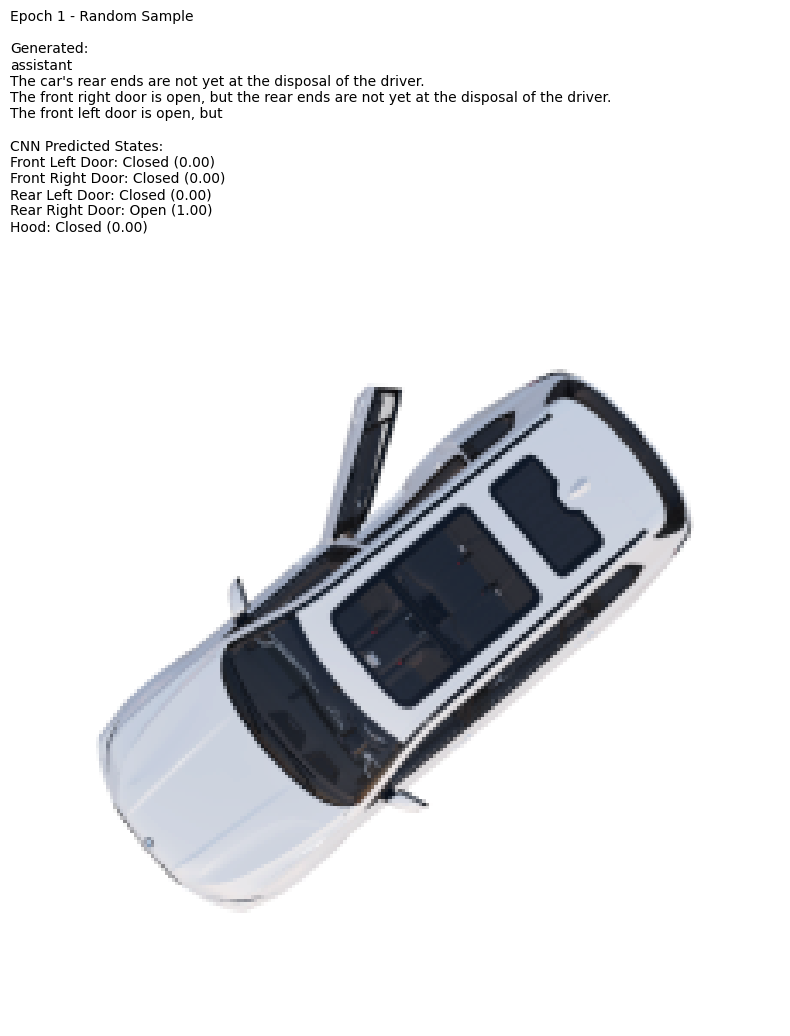

Sample image and text saved to car_llava_phase2/sample_epoch_1.png


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


New best model saved to car_llava_phase2/best_model with validation loss 2.9944


Epoch 2/20:   0%|          | 0/270 [00:00<?, ?it/s]

Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 2: Train Loss = 2.6844, Val Loss = 2.2925

Generating sample response...
Ground truth:  named SmolLM, trained by Hugging Face
<|im_start|>user
Examine this car image and describe which doors and hood are open or closed.
<image></image>
<|im_start|>assistant
The car's front left door and front right door are open. The rear left door, rear right door, and hood remain closed.

CNN Predicted States:
  Front Left Door: Open (1.00)
  Front Right Door: Open (1.00)
  Rear Left Door: Closed (0.00)
  Rear Right Door: Closed (0.00)
  Hood: Closed (0.00)
Sample generation:
assistant
The car's front left door and front right door are open. The rear left door, rear right door, and hood remain closed.

![Model 1](https://latex.codecogs.com/png


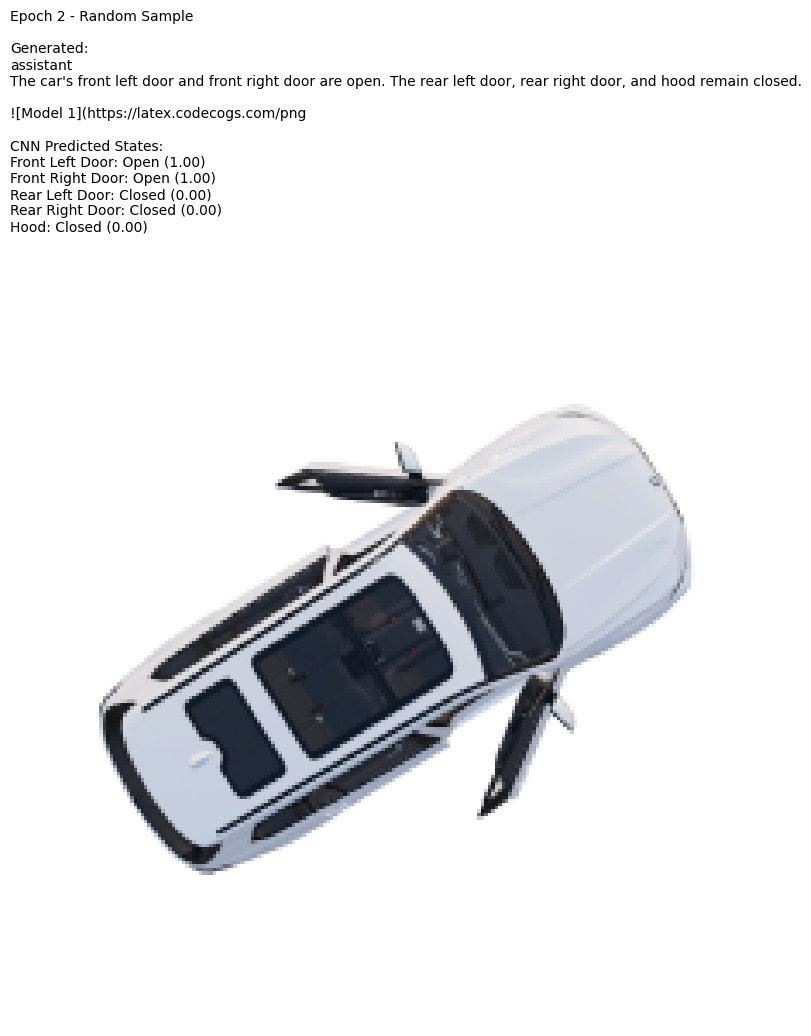

Sample image and text saved to car_llava_phase2/sample_epoch_2.png
New best model saved to car_llava_phase2/best_model with validation loss 2.2925


Epoch 3/20:   0%|          | 0/270 [00:00<?, ?it/s]

Saved checkpoint at step 200 to car_llava_phase2/checkpoint-step-200
Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 3: Train Loss = 1.9737, Val Loss = 1.6319

Generating sample response...
Ground truth:  named SmolLM, trained by Hugging Face
<|im_start|>user
Examine this car image and describe which doors and hood are open or closed.
<image></image>
<|im_start|>assistant
The car's front left door and hood are open. The front right door, rear left door, and rear right door remain closed.

CNN Predicted States:
  Front Left Door: Open (1.00)
  Front Right Door: Closed (0.00)
  Rear Left Door: Closed (0.00)
  Rear Right Door: Closed (0.00)
  Hood: Open (1.00)
Sample generation:
assistant
The car's front left door and hood are open. The front right door, rear left door, and rear right door remain closed.

The front left door, rear left door, and rear right door remain closed.



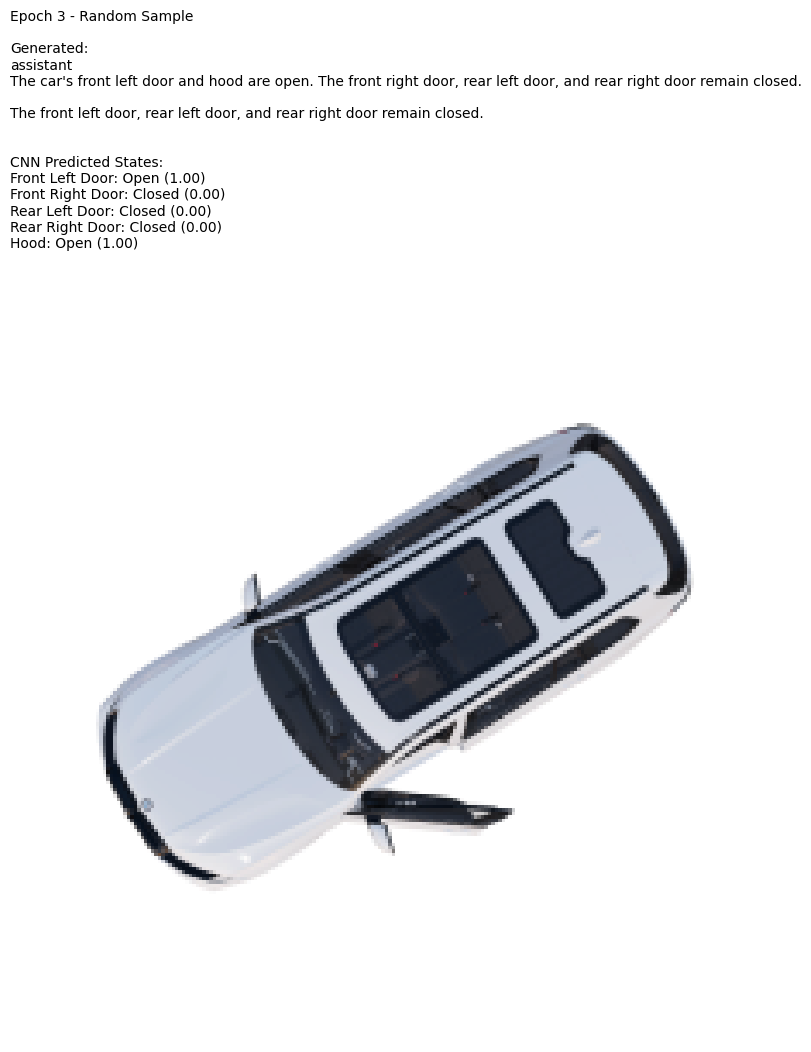

Sample image and text saved to car_llava_phase2/sample_epoch_3.png
New best model saved to car_llava_phase2/best_model with validation loss 1.6319


Epoch 4/20:   0%|          | 0/270 [00:00<?, ?it/s]

Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 4: Train Loss = 1.2779, Val Loss = 0.8043

Generating sample response...
Ground truth:  named SmolLM, trained by Hugging Face
<|im_start|>user
Examine this car image and describe which doors and hood are open or closed.
<image></image>
<|im_start|>assistant
The car's rear left door, rear right door, and hood are open. The front left door and front right door remain closed.

CNN Predicted States:
  Front Left Door: Closed (0.00)
  Front Right Door: Closed (0.00)
  Rear Left Door: Open (1.00)
  Rear Right Door: Open (1.00)
  Hood: Open (1.00)
Sample generation:
assistant
The car's rear left door, rear right door, and hood are open. The front left door and front right door remain closed. The front left door and front right door remain open. The rear left door and rear right door


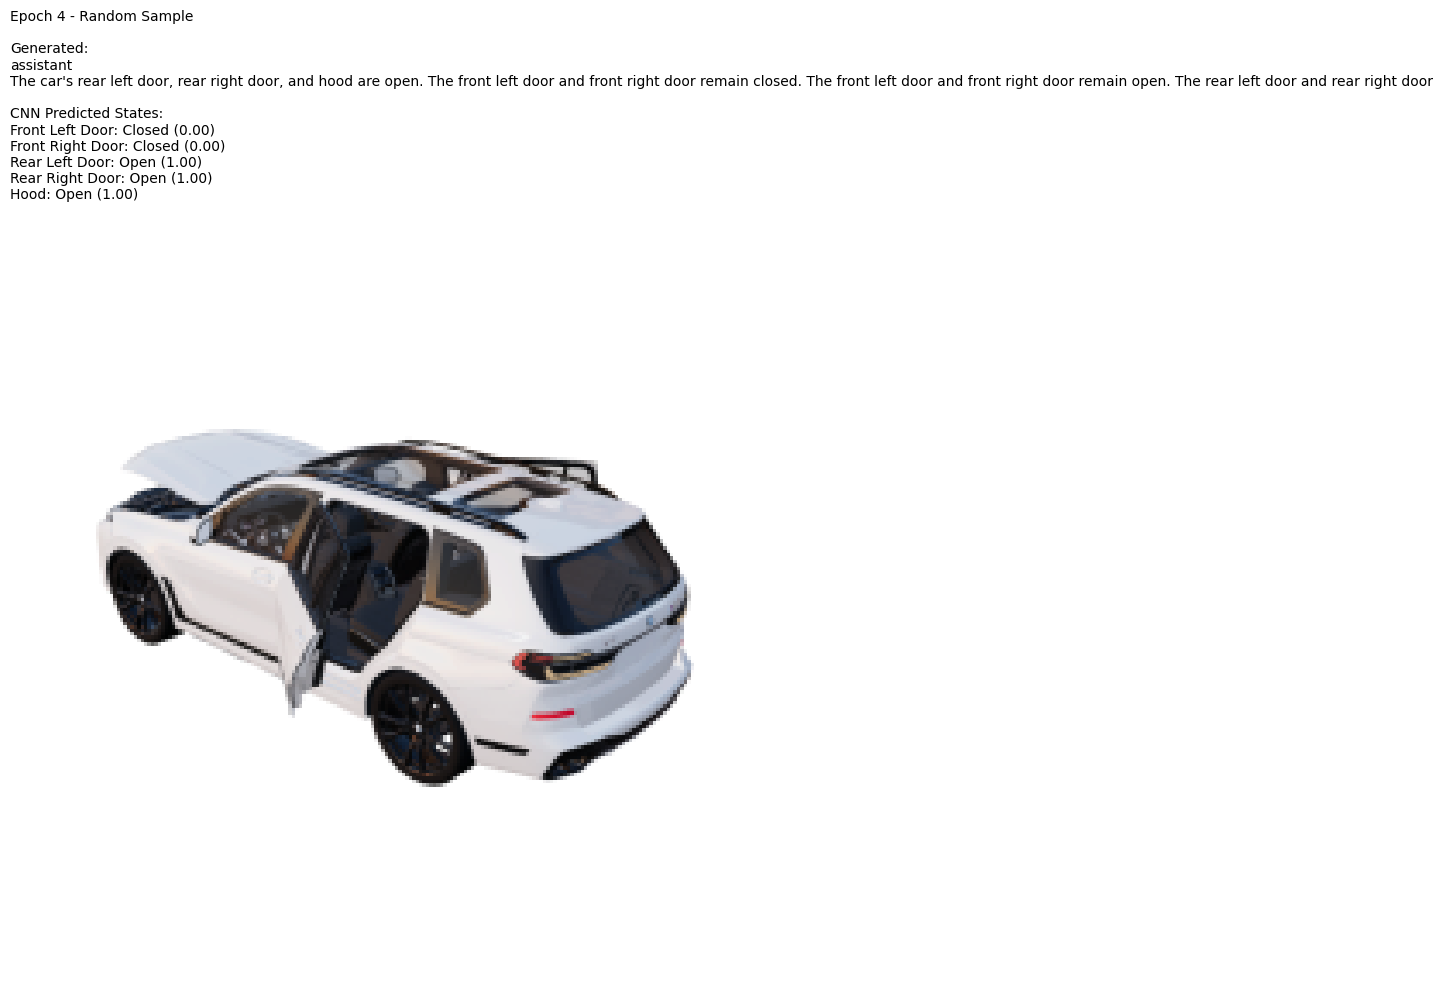

Sample image and text saved to car_llava_phase2/sample_epoch_4.png
New best model saved to car_llava_phase2/best_model with validation loss 0.8043


Epoch 5/20:   0%|          | 0/270 [00:00<?, ?it/s]

Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 5: Train Loss = 0.5970, Val Loss = 0.4916

Generating sample response...
Ground truth:  named SmolLM, trained by Hugging Face
<|im_start|>user
Examine this car image and describe which doors and hood are open or closed.
<image></image>
<|im_start|>assistant
The car's front left door, rear right door, and hood are open. The front right door and rear left door remain closed.

CNN Predicted States:
  Front Left Door: Open (1.00)
  Front Right Door: Closed (0.00)
  Rear Left Door: Closed (0.00)
  Rear Right Door: Open (1.00)
  Hood: Open (1.00)
Sample generation:
assistant
The car's front left door, rear right door, and hood are open. The front right door and rear left door remain closed.

Front left door:
Prev Day: 10/15/2


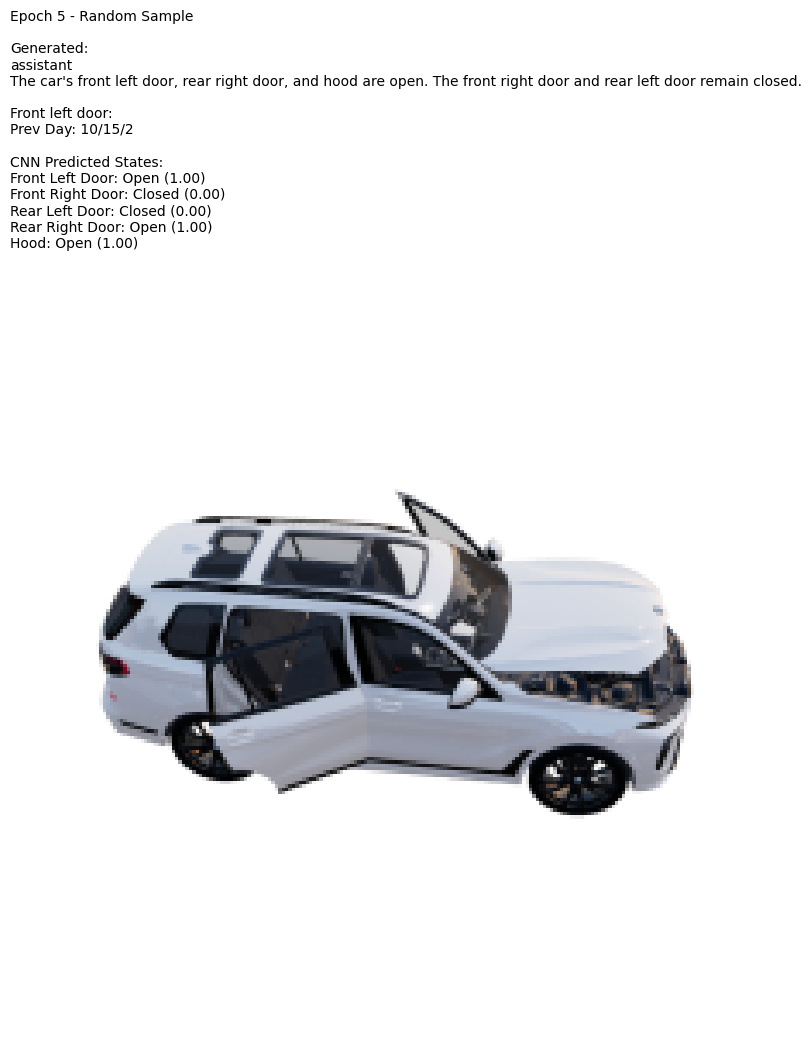

Sample image and text saved to car_llava_phase2/sample_epoch_5.png
New best model saved to car_llava_phase2/best_model with validation loss 0.4916


Epoch 6/20:   0%|          | 0/270 [00:00<?, ?it/s]

Saved checkpoint at step 400 to car_llava_phase2/checkpoint-step-400
Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 6: Train Loss = 0.4467, Val Loss = 0.4200

Generating sample response...
Ground truth:  named SmolLM, trained by Hugging Face
<|im_start|>user
Examine this car image and describe which doors and hood are open or closed.
<image></image>
<|im_start|>assistant
The car's front right door, rear left door, and hood are open. The front left door and rear right door remain closed.

CNN Predicted States:
  Front Left Door: Closed (0.00)
  Front Right Door: Open (1.00)
  Rear Left Door: Open (1.00)
  Rear Right Door: Closed (0.00)
  Hood: Open (1.00)
Sample generation:
assistant
The car's front right door, rear left door, and hood are open. The front left door and rear right door remain closed. The front right door's key is forward of the rear left door, and the rear left door


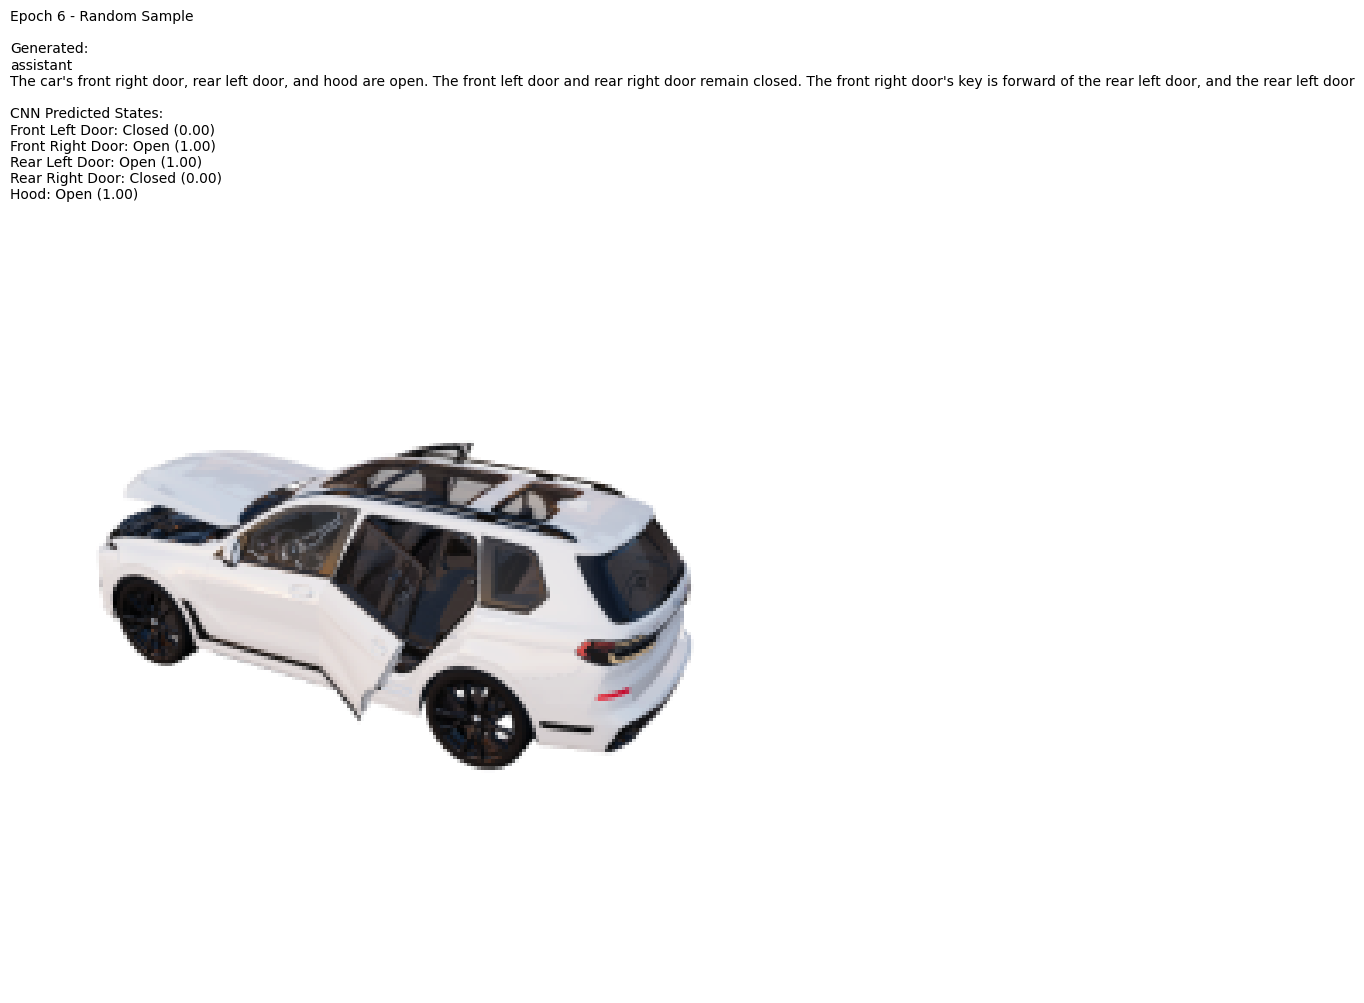

Sample image and text saved to car_llava_phase2/sample_epoch_6.png
New best model saved to car_llava_phase2/best_model with validation loss 0.4200


Epoch 7/20:   0%|          | 0/270 [00:00<?, ?it/s]

Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 7: Train Loss = 0.4076, Val Loss = 0.3939

Generating sample response...
Ground truth:  named SmolLM, trained by Hugging Face
<|im_start|>user
Examine this car image and describe which doors and hood are open or closed.
<image></image>
<|im_start|>assistant
The car's front left door, front right door, and rear right door are open. The rear left door and hood remain closed.

CNN Predicted States:
  Front Left Door: Open (1.00)
  Front Right Door: Open (1.00)
  Rear Left Door: Closed (0.00)
  Rear Right Door: Open (1.00)
  Hood: Closed (0.00)
Sample generation:
assistant
The car's front left door, front right door, and rear right door are open. The rear left door and hood remain closed.

Prevailing directions:

Down

Up

Rear left door


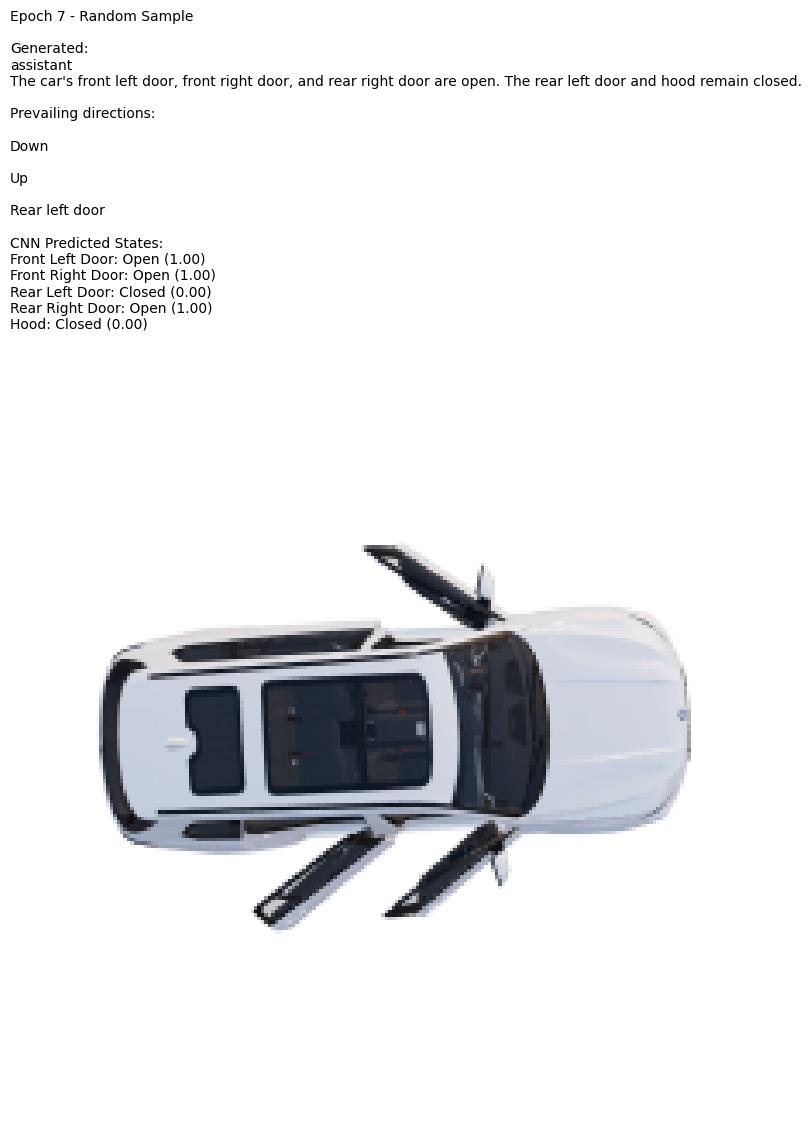

Sample image and text saved to car_llava_phase2/sample_epoch_7.png
New best model saved to car_llava_phase2/best_model with validation loss 0.3939


Epoch 8/20:   0%|          | 0/270 [00:00<?, ?it/s]

Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 8: Train Loss = 0.3879, Val Loss = 0.3792

Generating sample response...
Ground truth:  named SmolLM, trained by Hugging Face
<|im_start|>user
Examine this car image and describe which doors and hood are open or closed.
<image></image>
<|im_start|>assistant
All doors and the hood of the car are closed.

CNN Predicted States:
  Front Left Door: Closed (0.00)
  Front Right Door: Closed (0.00)
  Rear Left Door: Closed (0.00)
  Rear Right Door: Closed (0.00)
  Hood: Closed (0.00)
Sample generation:
assistant
All doors and the hood of the car are closed.


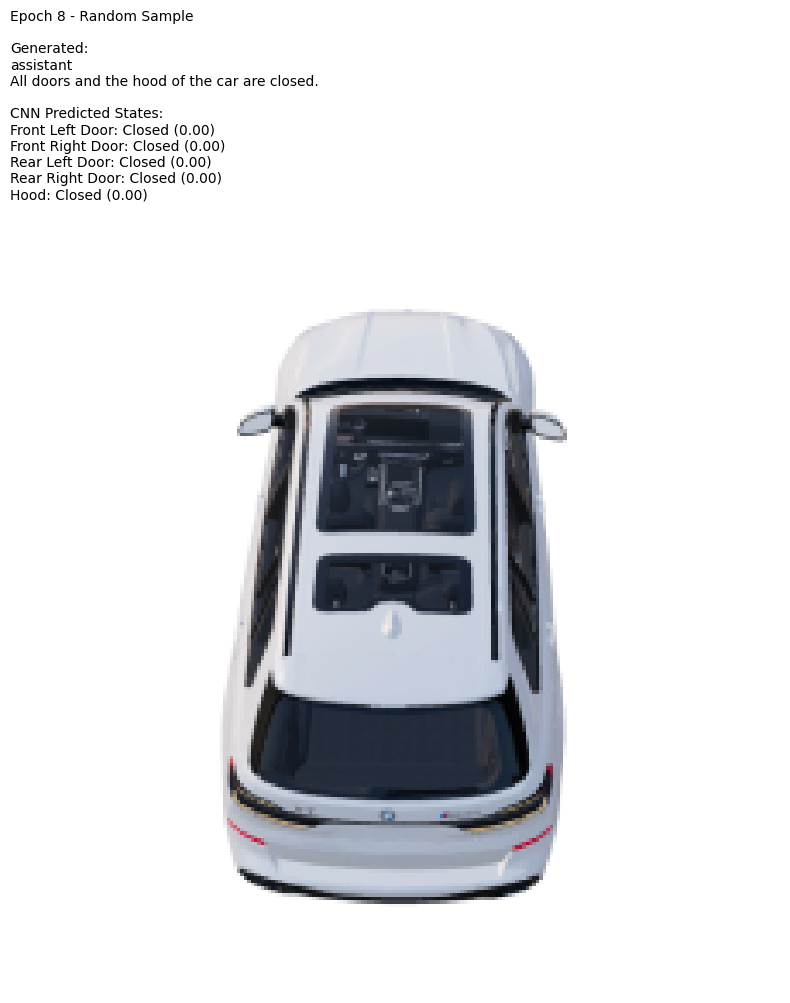

Sample image and text saved to car_llava_phase2/sample_epoch_8.png
New best model saved to car_llava_phase2/best_model with validation loss 0.3792


Epoch 9/20:   0%|          | 0/270 [00:00<?, ?it/s]

Saved checkpoint at step 600 to car_llava_phase2/checkpoint-step-600
Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 9: Train Loss = 0.3764, Val Loss = 0.3710

Generating sample response...
Ground truth:  named SmolLM, trained by Hugging Face
<|im_start|>user
Examine this car image and describe which doors and hood are open or closed.
<image></image>
<|im_start|>assistant
The car's rear left door and hood are open. The front left door, front right door, and rear right door remain closed.

CNN Predicted States:
  Front Left Door: Closed (0.00)
  Front Right Door: Closed (0.00)
  Rear Left Door: Open (1.00)
  Rear Right Door: Closed (0.00)
  Hood: Open (1.00)
Sample generation:
assistant
The car's rear left door and hood are open. The front left door, front right door, and rear right door remain closed.

Path: SmolLM
SmolLM
SmolLM
SmolLM


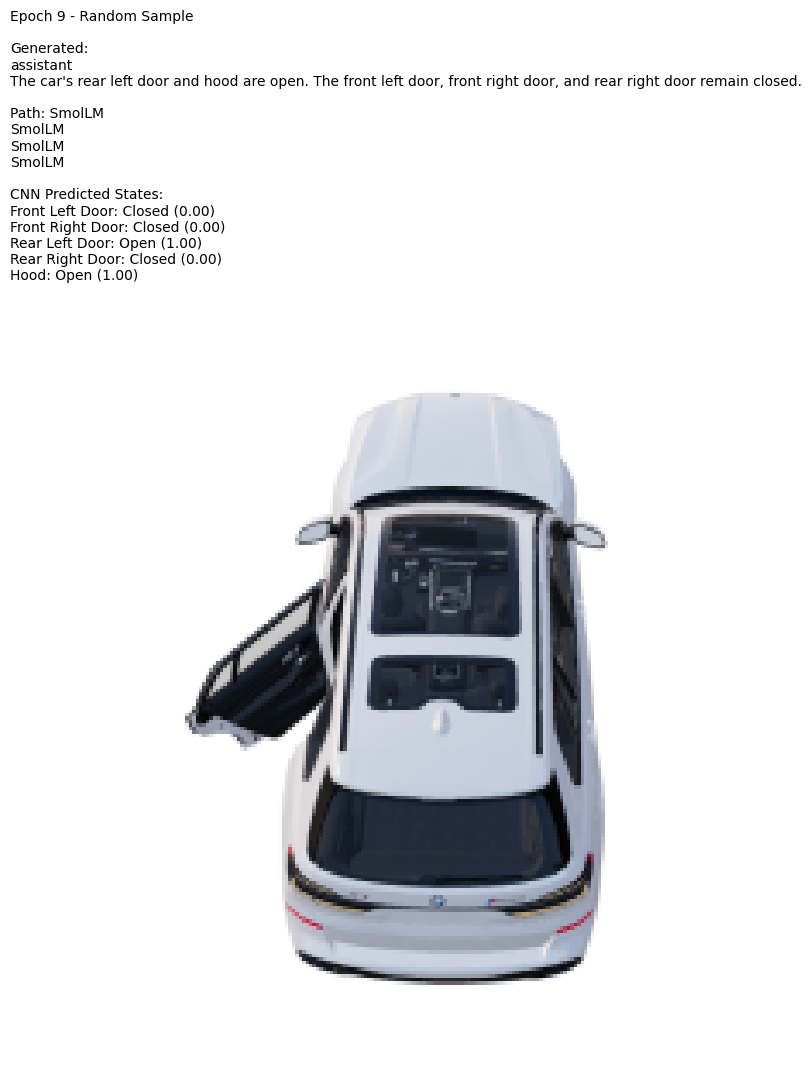

Sample image and text saved to car_llava_phase2/sample_epoch_9.png
New best model saved to car_llava_phase2/best_model with validation loss 0.3710


Epoch 10/20:   0%|          | 0/270 [00:00<?, ?it/s]

Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 10: Train Loss = 0.3686, Val Loss = 0.3649

Generating sample response...
Ground truth:  named SmolLM, trained by Hugging Face
<|im_start|>user
Examine this car image and describe which doors and hood are open or closed.
<image></image>
<|im_start|>assistant
All doors and the hood of the car are closed.

CNN Predicted States:
  Front Left Door: Closed (0.00)
  Front Right Door: Closed (0.00)
  Rear Left Door: Closed (0.00)
  Rear Right Door: Closed (0.00)
  Hood: Closed (0.00)
Sample generation:
assistant
All doors and the hood of the car are closed.


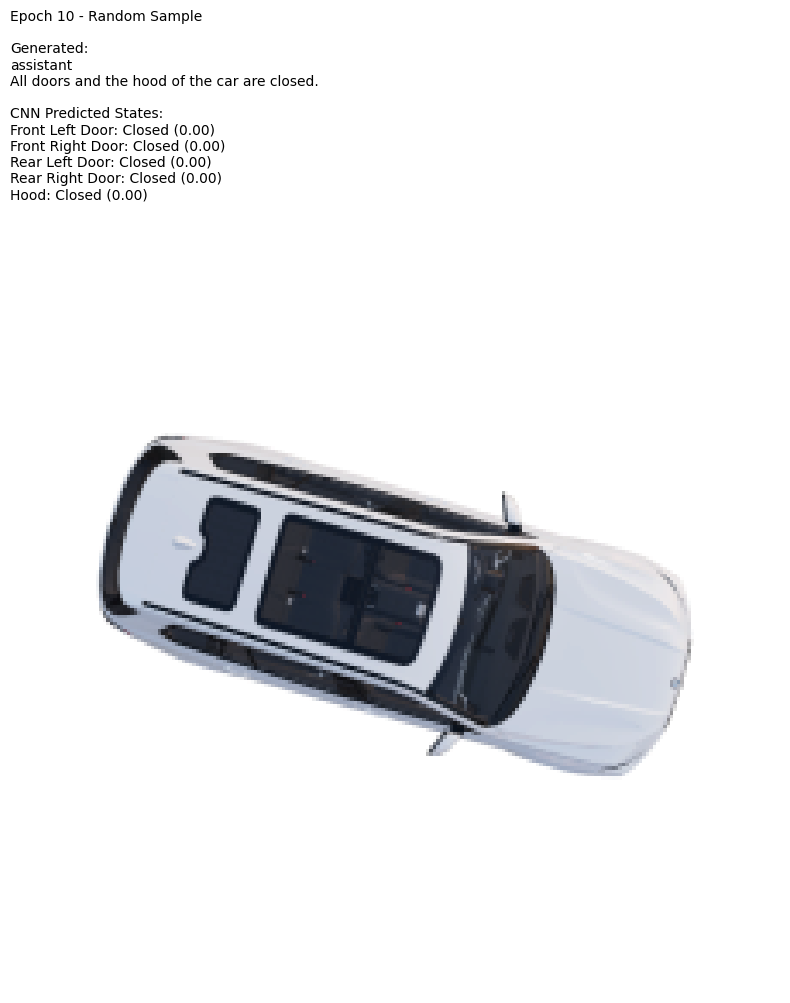

Sample image and text saved to car_llava_phase2/sample_epoch_10.png
New best model saved to car_llava_phase2/best_model with validation loss 0.3649


Epoch 11/20:   0%|          | 0/270 [00:00<?, ?it/s]

Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 11: Train Loss = 0.3631, Val Loss = 0.3599

Generating sample response...
Ground truth:  named SmolLM, trained by Hugging Face
<|im_start|>user
Examine this car image and describe which doors and hood are open or closed.
<image></image>
<|im_start|>assistant
The car's front right door, rear left door, and rear right door are open. The front left door and hood remain closed.

CNN Predicted States:
  Front Left Door: Closed (0.00)
  Front Right Door: Open (1.00)
  Rear Left Door: Open (1.00)
  Rear Right Door: Open (1.00)
  Hood: Closed (0.00)
Sample generation:
assistant
The car's front right door, rear left door, and rear right door are open. The front left door and hood remain closed.

<img src="https://s1.twitter.com/1592


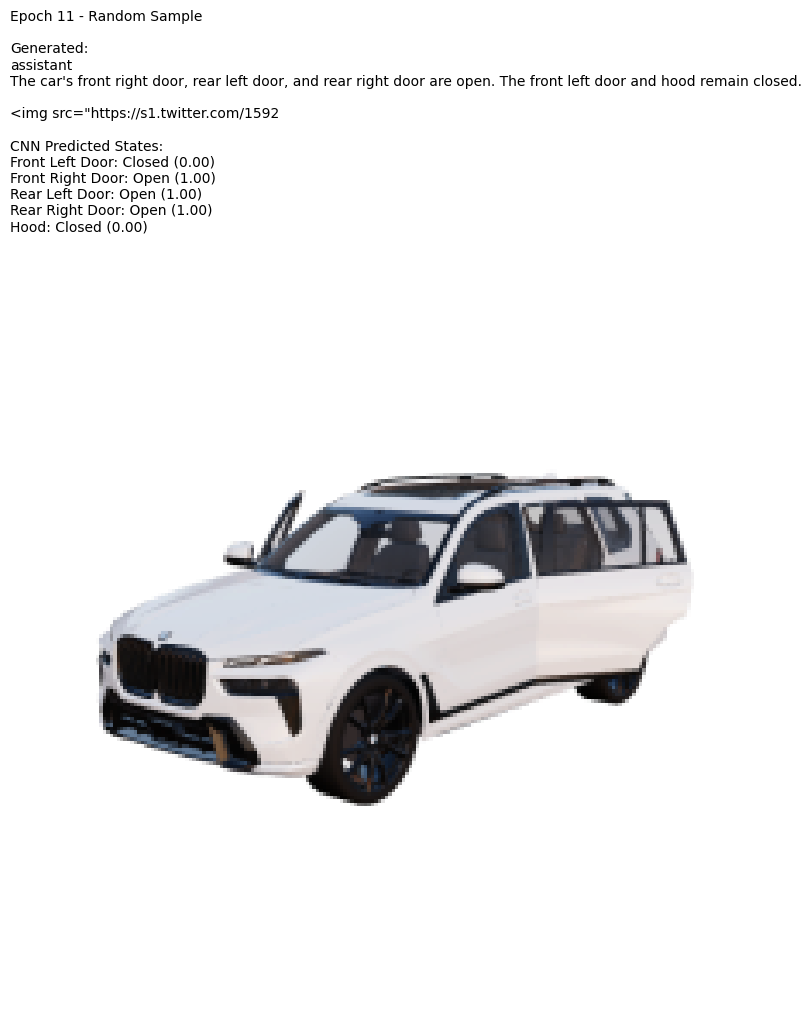

Sample image and text saved to car_llava_phase2/sample_epoch_11.png
New best model saved to car_llava_phase2/best_model with validation loss 0.3599


Epoch 12/20:   0%|          | 0/270 [00:00<?, ?it/s]

Saved checkpoint at step 800 to car_llava_phase2/checkpoint-step-800
Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 12: Train Loss = 0.3585, Val Loss = 0.3566

Generating sample response...
Ground truth:  named SmolLM, trained by Hugging Face
<|im_start|>user
Examine this car image and describe which doors and hood are open or closed.
<image></image>
<|im_start|>assistant
The car's rear right door and hood are open. The front left door, front right door, and rear left door remain closed.

CNN Predicted States:
  Front Left Door: Closed (0.00)
  Front Right Door: Closed (0.00)
  Rear Left Door: Closed (0.00)
  Rear Right Door: Open (1.00)
  Hood: Open (1.00)
Sample generation:
assistant
The car's rear right door and hood are open. The front left door, front right door, and rear left door remain closed.

Prevailing views

Listing options

Doors and hood



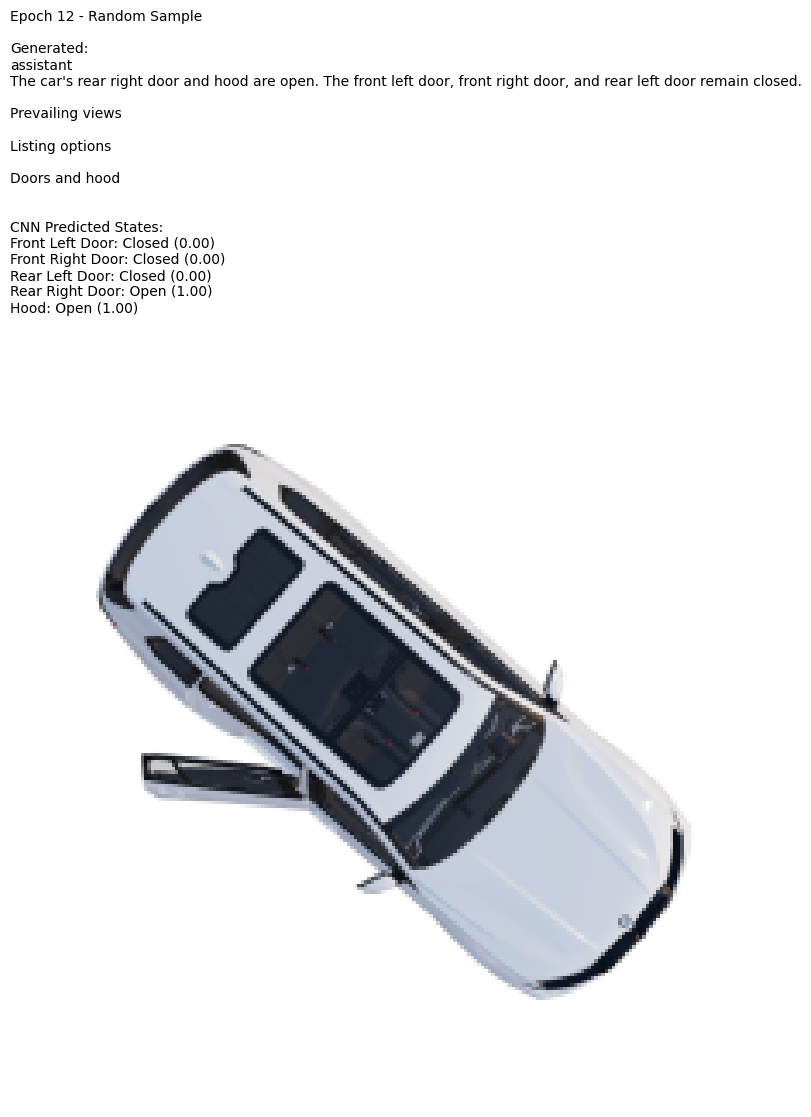

Sample image and text saved to car_llava_phase2/sample_epoch_12.png
New best model saved to car_llava_phase2/best_model with validation loss 0.3566


Epoch 13/20:   0%|          | 0/270 [00:00<?, ?it/s]

Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 13: Train Loss = 0.3557, Val Loss = 0.3546

Generating sample response...
Ground truth:  named SmolLM, trained by Hugging Face
<|im_start|>user
Examine this car image and describe which doors and hood are open or closed.
<image></image>
<|im_start|>assistant
The car's front right door and rear left door are open. The front left door, rear right door, and hood remain closed.

CNN Predicted States:
  Front Left Door: Closed (0.00)
  Front Right Door: Open (1.00)
  Rear Left Door: Open (1.00)
  Rear Right Door: Closed (0.00)
  Hood: Closed (0.00)
Sample generation:
assistant
The car's front right door and rear left door are open. The front left door, rear right door, and hood remain closed.

<img src="images/car-right-door.jpg" width="1


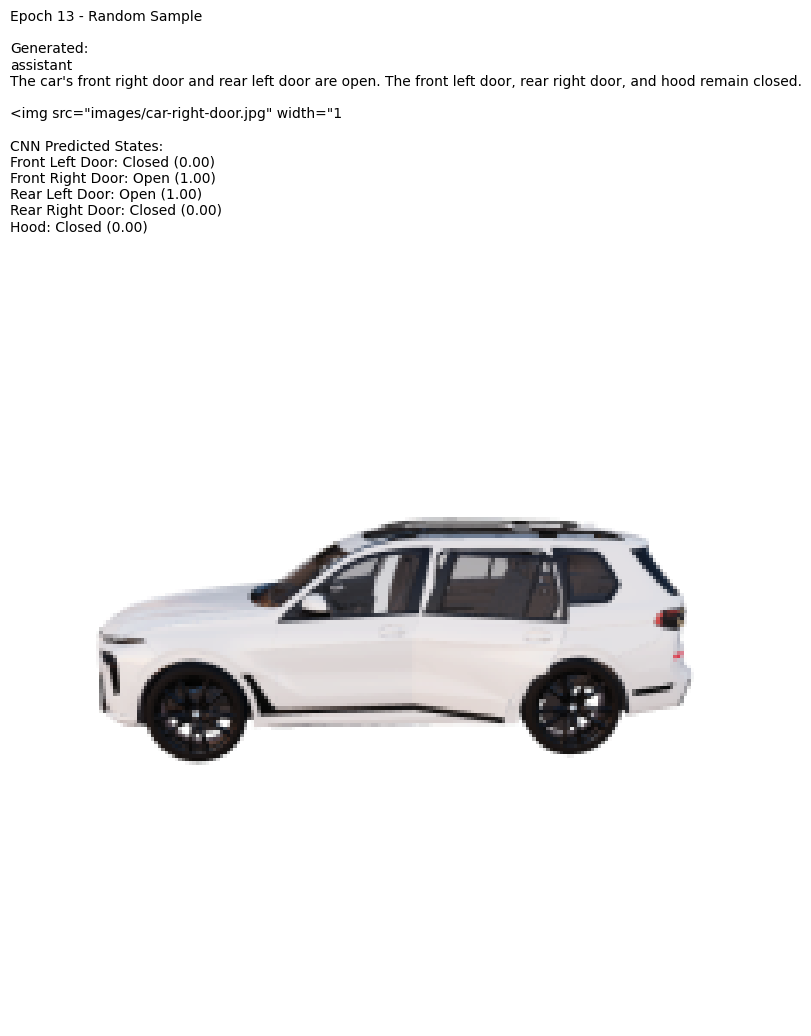

Sample image and text saved to car_llava_phase2/sample_epoch_13.png
New best model saved to car_llava_phase2/best_model with validation loss 0.3546


Epoch 14/20:   0%|          | 0/270 [00:00<?, ?it/s]

Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 14: Train Loss = 0.3539, Val Loss = 0.3532

Generating sample response...
Ground truth:  named SmolLM, trained by Hugging Face
<|im_start|>user
Examine this car image and describe which doors and hood are open or closed.
<image></image>
<|im_start|>assistant
The car's rear left door and rear right door are open. The front left door, front right door, and hood remain closed.

CNN Predicted States:
  Front Left Door: Closed (0.00)
  Front Right Door: Closed (0.00)
  Rear Left Door: Open (1.00)
  Rear Right Door: Open (1.00)
  Hood: Closed (0.00)
Sample generation:
assistant
The car's rear left door and rear right door are open. The front left door, front right door, and hood remain closed.

Prevailing Waze View

Road Conditions

Road Conditions

Road


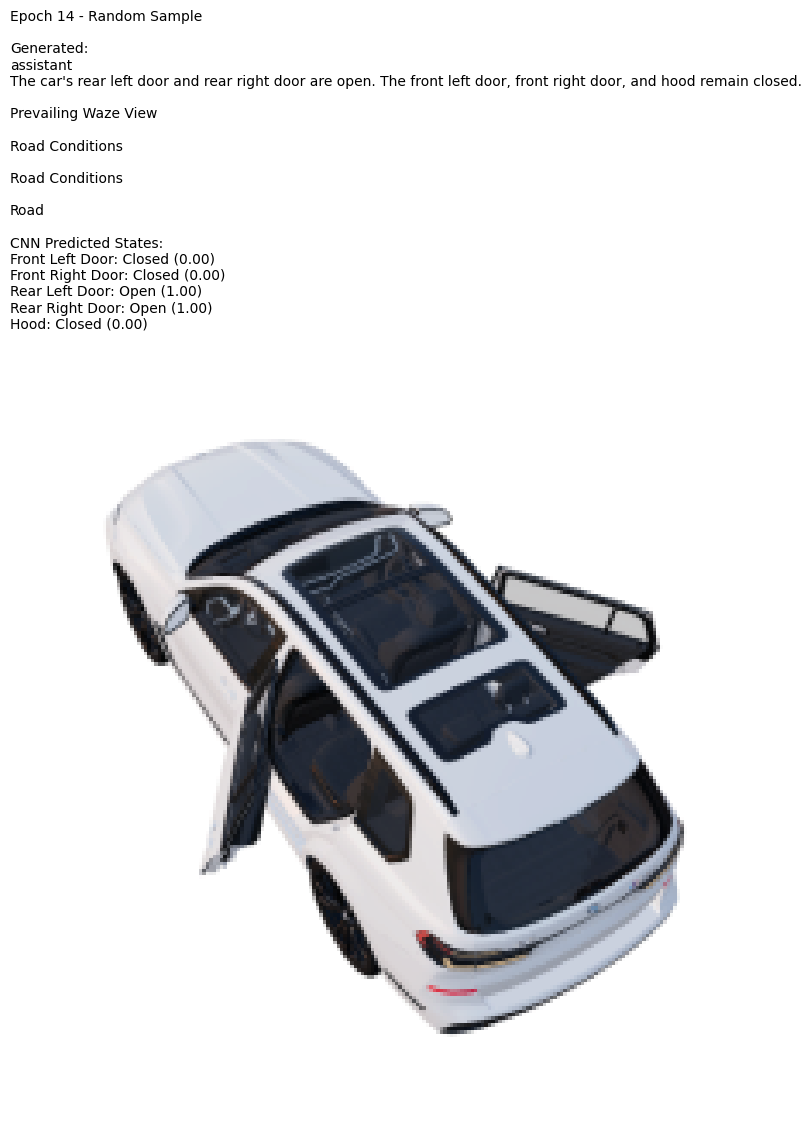

Sample image and text saved to car_llava_phase2/sample_epoch_14.png
New best model saved to car_llava_phase2/best_model with validation loss 0.3532


Epoch 15/20:   0%|          | 0/270 [00:00<?, ?it/s]

Saved checkpoint at step 1000 to car_llava_phase2/checkpoint-step-1000
Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 15: Train Loss = 0.3527, Val Loss = 0.3519

Generating sample response...
Ground truth:  named SmolLM, trained by Hugging Face
<|im_start|>user
Examine this car image and describe which doors and hood are open or closed.
<image></image>
<|im_start|>assistant
All doors and the hood of the car are closed.

CNN Predicted States:
  Front Left Door: Closed (0.00)
  Front Right Door: Closed (0.00)
  Rear Left Door: Closed (0.00)
  Rear Right Door: Closed (0.00)
  Hood: Closed (0.00)
Sample generation:
assistant
All doors and the hood of the car are closed.


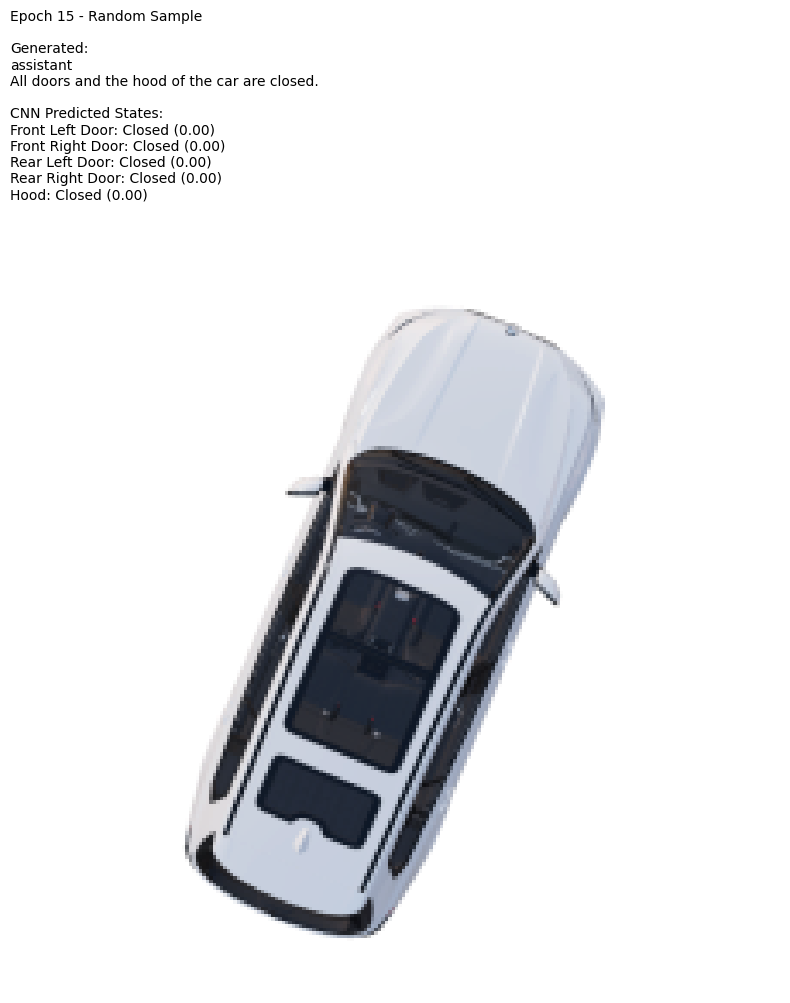

Sample image and text saved to car_llava_phase2/sample_epoch_15.png
New best model saved to car_llava_phase2/best_model with validation loss 0.3519


Epoch 16/20:   0%|          | 0/270 [00:00<?, ?it/s]

Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 16: Train Loss = 0.3517, Val Loss = 0.3512

Generating sample response...
Ground truth:  named SmolLM, trained by Hugging Face
<|im_start|>user
Examine this car image and describe which doors and hood are open or closed.
<image></image>
<|im_start|>assistant
The car's front left door and hood are open. The front right door, rear left door, and rear right door remain closed.

CNN Predicted States:
  Front Left Door: Open (1.00)
  Front Right Door: Closed (0.00)
  Rear Left Door: Closed (0.00)
  Rear Right Door: Closed (0.00)
  Hood: Open (1.00)
Sample generation:
assistant
The car's front left door and hood are open. The front right door, rear left door, and rear right door remain closed.

<img src="https://s1.twitter.com/36.3


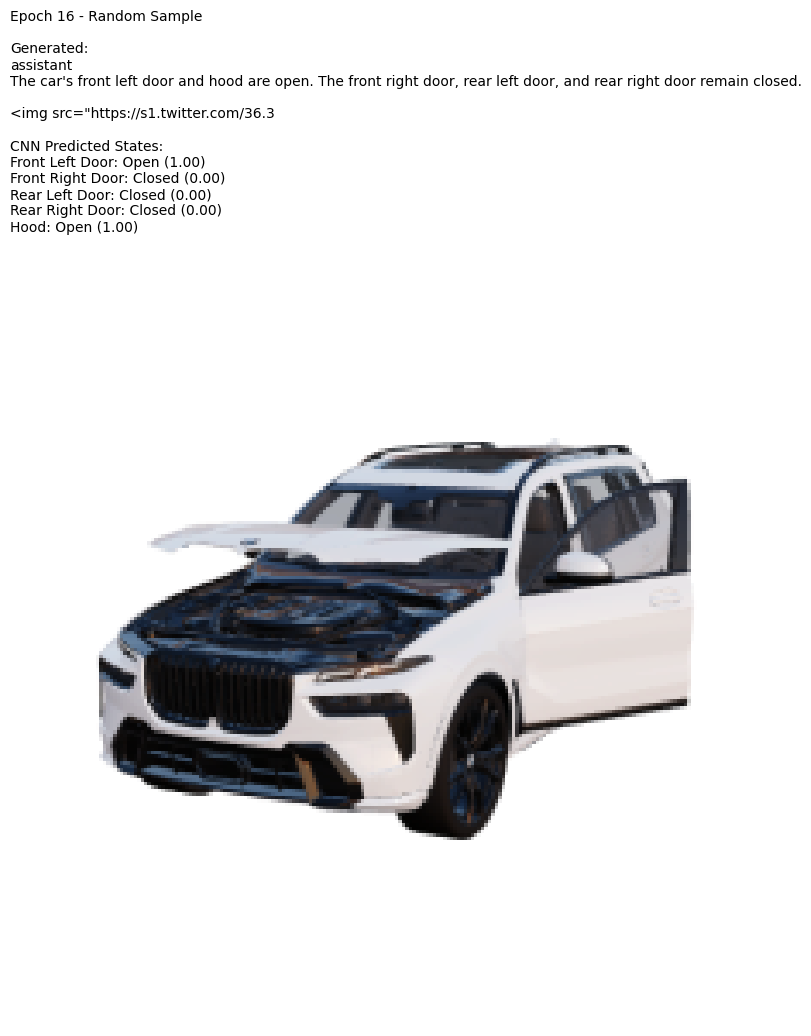

Sample image and text saved to car_llava_phase2/sample_epoch_16.png
New best model saved to car_llava_phase2/best_model with validation loss 0.3512


Epoch 17/20:   0%|          | 0/270 [00:00<?, ?it/s]

Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 17: Train Loss = 0.3512, Val Loss = 0.3506

Generating sample response...
Ground truth:  named SmolLM, trained by Hugging Face
<|im_start|>user
Examine this car image and describe which doors and hood are open or closed.
<image></image>
<|im_start|>assistant
The car's front left door and front right door are open. The rear left door, rear right door, and hood remain closed.

CNN Predicted States:
  Front Left Door: Open (1.00)
  Front Right Door: Open (1.00)
  Rear Left Door: Closed (0.00)
  Rear Right Door: Closed (0.00)
  Hood: Closed (0.00)
Sample generation:
assistant
The car's front left door and front right door are open. The rear left door, rear right door, and hood remain closed.


What model of vehicles is this?
This model is a prototype of the Toyota Cam


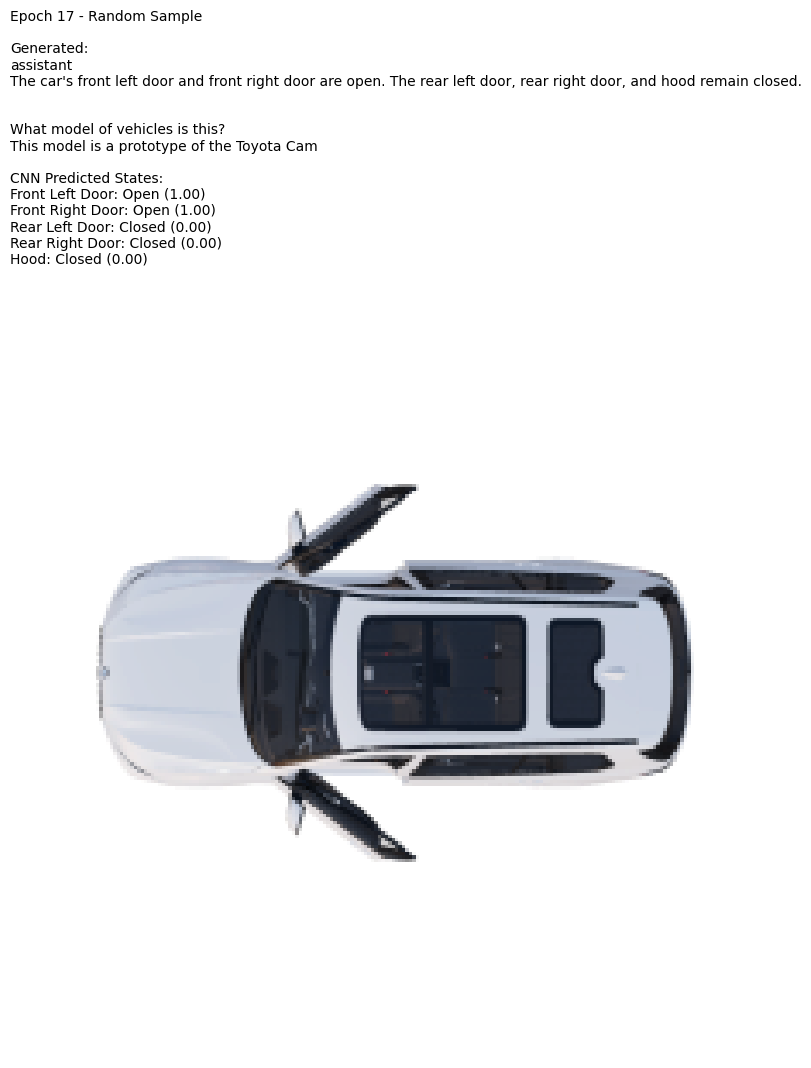

Sample image and text saved to car_llava_phase2/sample_epoch_17.png
New best model saved to car_llava_phase2/best_model with validation loss 0.3506


Epoch 18/20:   0%|          | 0/270 [00:00<?, ?it/s]

Saved checkpoint at step 1200 to car_llava_phase2/checkpoint-step-1200
Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 18: Train Loss = 0.3507, Val Loss = 0.3504

Generating sample response...
Ground truth:  named SmolLM, trained by Hugging Face
<|im_start|>user
Examine this car image and describe which doors and hood are open or closed.
<image></image>
<|im_start|>assistant
The car's front right door and rear left door are open. The front left door, rear right door, and hood remain closed.

CNN Predicted States:
  Front Left Door: Closed (0.00)
  Front Right Door: Open (1.00)
  Rear Left Door: Open (1.00)
  Rear Right Door: Closed (0.00)
  Hood: Closed (0.00)
Sample generation:
assistant
The car's front right door and rear left door are open. The front left door, rear right door, and hood remain closed.

<img src="https://s3-2.amazonaws.com/h


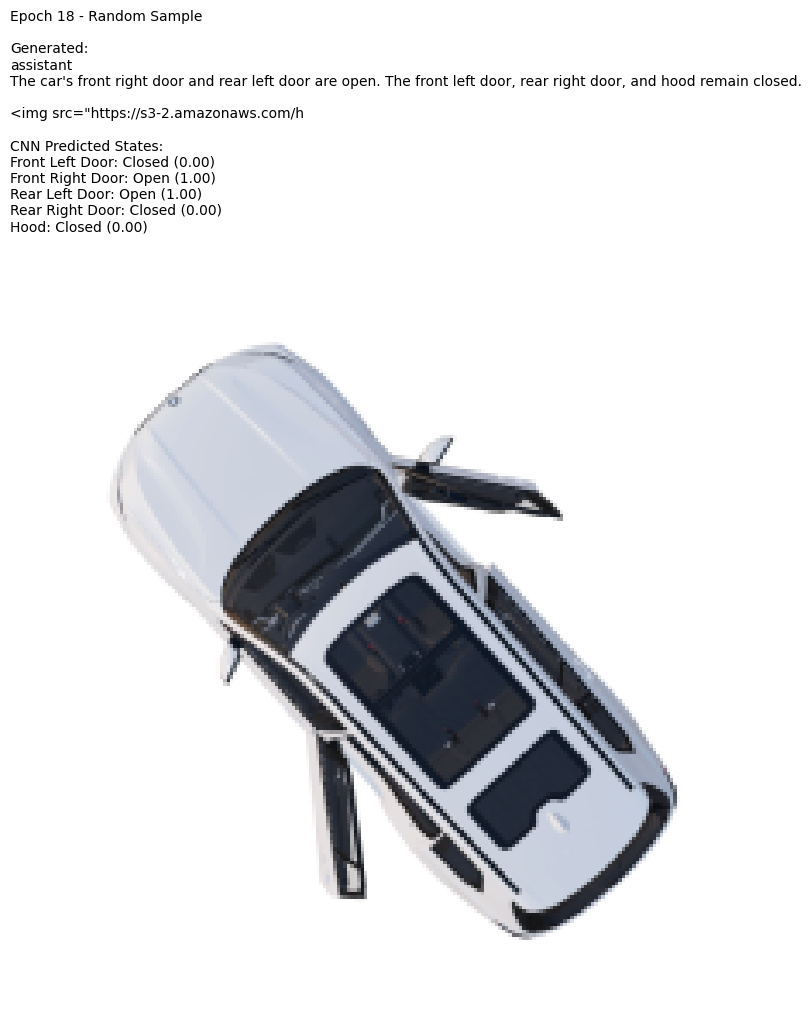

Sample image and text saved to car_llava_phase2/sample_epoch_18.png
New best model saved to car_llava_phase2/best_model with validation loss 0.3504


Epoch 19/20:   0%|          | 0/270 [00:00<?, ?it/s]

Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 19: Train Loss = 0.3504, Val Loss = 0.3500

Generating sample response...
Ground truth:  named SmolLM, trained by Hugging Face
<|im_start|>user
Examine this car image and describe which doors and hood are open or closed.
<image></image>
<|im_start|>assistant
The car's front left door, front right door, rear left door, and hood are open. The rear right door remains closed.

CNN Predicted States:
  Front Left Door: Open (1.00)
  Front Right Door: Open (1.00)
  Rear Left Door: Open (1.00)
  Rear Right Door: Closed (0.00)
  Hood: Open (1.00)
Sample generation:
assistant
The car's front left door, front right door, rear left door, and hood are open. The rear right door remains closed.

What is the name of the car's front left door?


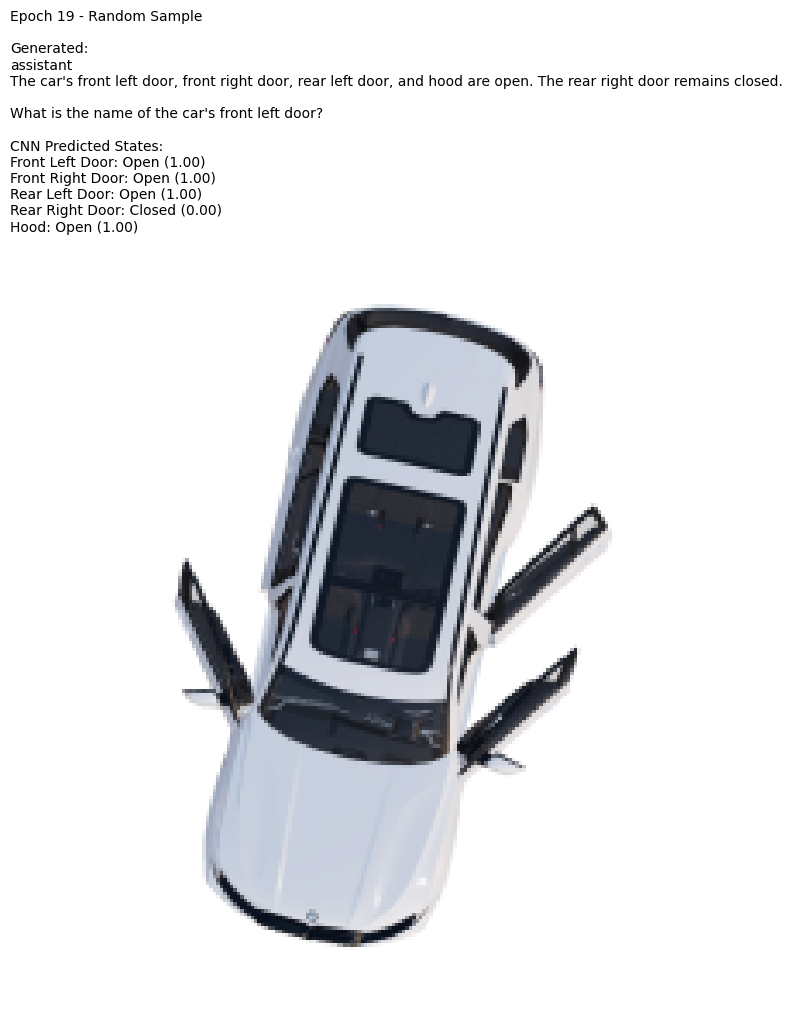

Sample image and text saved to car_llava_phase2/sample_epoch_19.png
New best model saved to car_llava_phase2/best_model with validation loss 0.3500


Epoch 20/20:   0%|          | 0/270 [00:00<?, ?it/s]

Running validation...


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 20: Train Loss = 0.3501, Val Loss = 0.3500

Generating sample response...
Ground truth:  named SmolLM, trained by Hugging Face
<|im_start|>user
Examine this car image and describe which doors and hood are open or closed.
<image></image>
<|im_start|>assistant
The car's front left door, rear left door, and hood are open. The front right door and rear right door remain closed.

CNN Predicted States:
  Front Left Door: Open (1.00)
  Front Right Door: Closed (0.00)
  Rear Left Door: Open (1.00)
  Rear Right Door: Closed (0.00)
  Hood: Open (1.00)
Sample generation:
assistant
The car's front left door, rear left door, and hood are open. The front right door and rear right door remain closed.

<p>
 The front left door and rear left door were previously open, but


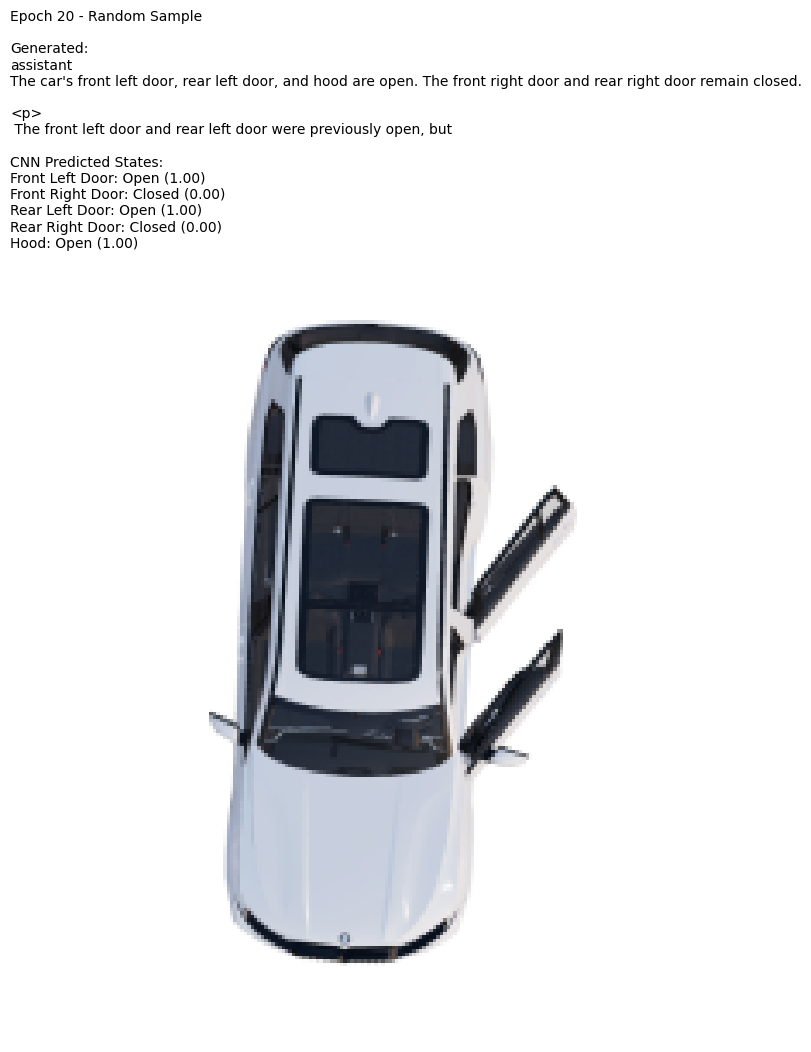

Sample image and text saved to car_llava_phase2/sample_epoch_20.png
New best model saved to car_llava_phase2/best_model with validation loss 0.3500
Final model saved to car_llava_phase2/final_model
Phase 2 training complete!


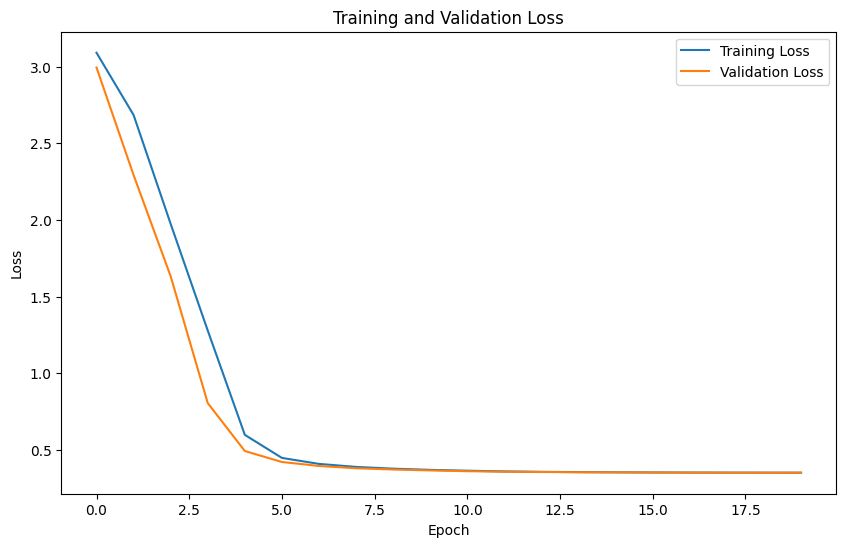

In [5]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import get_linear_schedule_with_warmup
from PIL import Image
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training




# Configuration
CONFIG = {
    "dataset_path": "/kaggle/input/3dcardata/car_state_dataset_multilabel",
    "text_labels_path": "/kaggle/working/text_labels.csv",
    "cnn_model_path": "/kaggle/input/car_component_classifier/pytorch/default/1/car_component_classifier_model_resnet50_max.pt",
    "llm_model_path": "HuggingFaceTB/SmolLM2-135M-Instruct",
    "phase1_model_path": "car_llava_phase1/best_projection_layer.pt",
    "output_dir": "car_llava_phase2",
    "batch_size": 16,
    "gradient_accumulation_steps": 4,
    "epochs": 20,
    "projection_lr": 5e-5,      # Lower learning rate for pre-trained projection layer
    "lora_lr": 2e-5,            # Learning rate for LoRA parameters
    "warmup_ratio": 0.05,
    "max_length": 256,
    "image_size": 224,
    "feature_dim": 2048,        # CNN feature dimension for ResNet50
    "classifier_dim": 5,        # Number of car components
    "hidden_dim": 768,          # Projection hidden dimension
    "llm_embedding_dim": 576,   # SmolLM2 embedding dimension
    "save_every_steps": 200,
    "weight_decay": 0.03,       # Increased weight decay
    # LoRA configuration
    "lora_r": 16,               # LoRA rank
    "lora_alpha": 32,           # LoRA alpha scaling
    "lora_dropout": 0.05        # LoRA dropout
}

# Ensure output directory exists
os.makedirs(CONFIG["output_dir"], exist_ok=True)


class CarLLaVA_Phase2(nn.Module):
    """
    Phase 2 of Car-LLaVA model: 
    - Projection layer initialized from Phase 1
    - LLM partially unfrozen and fine-tuned with LoRA
    """
    
    def __init__(self, 
                 cnn_model_path,              # Path to fine-tuned car component model
                 llm_model_path,              # Path to LLM
                 phase1_model_path,           # Path to trained projection layer from Phase 1
                 projection_hidden_dim=768,   # Hidden dim for projection layer
                 vision_feature_dim=2048,     # CNN feature dimension
                 vision_classifier_dim=5,     # Number of components
                 llm_embedding_dim=576,       # SmolLM2 embedding dimension
                 lora_r=16,                   # LoRA rank
                 lora_alpha=32,               # LoRA alpha
                 lora_dropout=0.05):          # LoRA dropout
        super().__init__()
        
        # Load CNN classifier model (includes both feature extractor and classifier)
        self.vision_model = ComponentClassifier(embedding_dim=256)
        checkpoint = torch.load(cnn_model_path)
        self.vision_model.load_state_dict(checkpoint['model_state_dict'])
        
        # Freeze CNN
        for param in self.vision_model.parameters():
            param.requires_grad = False
        print("CNN model loaded and frozen")
        
        # Load tokenizer and add special tokens
        self.tokenizer = AutoTokenizer.from_pretrained(llm_model_path)
        special_tokens = {"additional_special_tokens": ["<image>", "</image>"]}
        num_added = self.tokenizer.add_special_tokens(special_tokens)
        print(f"Added {num_added} special tokens to tokenizer")
        
        # Create projection layer
        self.projection_layer = VisionProjectionLayer(
            vision_feature_dim=vision_feature_dim,
            vision_classifier_dim=vision_classifier_dim,
            llm_embedding_dim=llm_embedding_dim,
            hidden_dim=projection_hidden_dim
        )
        
        # Load pre-trained projection layer weights from Phase 1
        try:
            projection_state_dict = torch.load(phase1_model_path)
            # Check if the keys match the current model
            matched_keys = 0
            for key in projection_state_dict.keys():
                if key in self.projection_layer.state_dict():
                    matched_keys += 1
            
            print(f"Found {matched_keys} matching keys in projection layer checkpoint")
            
            # Handle potential size mismatch if the model architecture changed
            if matched_keys / len(projection_state_dict.keys()) >= 0.5:  # At least 50% keys match
                # Create a new state dict with matching keys only
                cleaned_state_dict = {k: v for k, v in projection_state_dict.items() 
                                    if k in self.projection_layer.state_dict() and 
                                    v.shape == self.projection_layer.state_dict()[k].shape}
                
                # Load the matched weights
                self.projection_layer.load_state_dict(cleaned_state_dict, strict=False)
                print(f"Loaded {len(cleaned_state_dict)}/{len(self.projection_layer.state_dict())} layers from Phase 1 checkpoint")
            else:
                print("Warning: Phase 1 checkpoint structure doesn't match. Using random initialization.")
        except Exception as e:
            print(f"Error loading Phase 1 projection layer: {e}")
            print("Using random initialization for projection layer")
        
        # Load LLM 
        self.llm = AutoModelForCausalLM.from_pretrained(llm_model_path)
        
        # Resize token embeddings to account for new special tokens
        self.llm.resize_token_embeddings(len(self.tokenizer))
        
        # Apply LoRA to specific attention layers
        lora_target_modules = [
            "q_proj", 
            "k_proj",
            "v_proj", 
            "o_proj"
        ]
        
        # Configure LoRA
        self.lora_config = LoraConfig(
            r=lora_r,
            lora_alpha=lora_alpha,
            target_modules=lora_target_modules,
            lora_dropout=lora_dropout,
            bias="none",
            task_type="CAUSAL_LM"
        )
        
        # Prepare model for LoRA fine-tuning
        self.llm = get_peft_model(self.llm, self.lora_config)
        self.llm.print_trainable_parameters()  # Print percentage of trainable parameters
    
    def forward(self, images, input_ids, attention_mask=None):
        # Process images through CNN (with gradients disabled)
        with torch.no_grad():
            self.vision_model.eval()
            logits, features, _ = self.vision_model(images, return_features=True)
            sigmoid_outputs = torch.sigmoid(logits)  # Get probabilities for component states
        
        # Project visual features to LLM embedding space
        visual_embedding = self.projection_layer(features, sigmoid_outputs)
        
        # Find positions of image tokens in the input
        batch_size = input_ids.shape[0]
        image_token_id = self.tokenizer.convert_tokens_to_ids("<image>")
        
        # Get LLM input embeddings
        llm_inputs = self.llm.get_input_embeddings()(input_ids)
        
        # Replace <image> token embeddings with visual embeddings
        for b in range(batch_size):
            # Find the position of <image> token
            image_positions = (input_ids[b] == image_token_id).nonzero(as_tuple=True)[0]
            if len(image_positions) > 0:
                # Replace the embedding at the <image> position
                image_pos = image_positions[0]
                llm_inputs[b, image_pos] = visual_embedding[b]
        
        # Forward pass through LLM
        outputs = self.llm(
            inputs_embeds=llm_inputs,
            attention_mask=attention_mask,
            return_dict=True
        )
        
        return outputs



def train_phase2():
    """Train Phase 2 of Car-LLaVA: LLM adaptation via LoRA"""
    
    print("Starting Phase 2 training: LLM adaptation")
    
    # Set up data transforms
    transform = transforms.Compose([
        transforms.Resize((CONFIG["image_size"], CONFIG["image_size"])),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Initialize model
    print("Initializing Car-LLaVA Phase 2 model")
    model = CarLLaVA_Phase2(
        cnn_model_path=CONFIG["cnn_model_path"],
        llm_model_path=CONFIG["llm_model_path"],
        phase1_model_path=CONFIG["phase1_model_path"],
        projection_hidden_dim=CONFIG["hidden_dim"],
        vision_feature_dim=CONFIG["feature_dim"],
        vision_classifier_dim=CONFIG["classifier_dim"],
        llm_embedding_dim=CONFIG["llm_embedding_dim"],
        lora_r=CONFIG["lora_r"],
        lora_alpha=CONFIG["lora_alpha"],
        lora_dropout=CONFIG["lora_dropout"]
    )
    
    # Create dataset
    print(f"Loading dataset from {CONFIG['text_labels_path']}")
    dataset = CarLLaVADataset(
        image_dir=CONFIG["dataset_path"],
        text_labels_path=CONFIG["text_labels_path"],
        tokenizer=model.tokenizer,
        transform=transform,
        max_length=CONFIG["max_length"]
    )
    
    # Split dataset
    train_size = int(0.9 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    print(f"Dataset split: {train_size} training, {val_size} validation samples")
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=CONFIG["batch_size"],
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        persistent_workers=True,
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=CONFIG["batch_size"],
        shuffle=False,
        num_workers=4,
        pin_memory=True,
        persistent_workers=True,
    )
    
    # Set up optimizer with different learning rates for different components
    optimizer_grouped_parameters = [
        {
            "params": model.projection_layer.parameters(),
            "lr": CONFIG["projection_lr"],
            "weight_decay": CONFIG["weight_decay"]
        },
        {
            "params": model.llm.parameters(),
            "lr": CONFIG["lora_lr"],
            "weight_decay": CONFIG["weight_decay"] * 0.5  # Lower weight decay for LoRA params
        }
    ]
    
    optimizer = optim.AdamW(
        optimizer_grouped_parameters,
        betas=(0.9, 0.999)
    )
    
    # Calculate total training steps
    total_steps = len(train_loader) * CONFIG["epochs"] // CONFIG["gradient_accumulation_steps"]
    warmup_steps = int(total_steps * CONFIG["warmup_ratio"])
    
    # Set up learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps
    )
    
    print(f"Training for {CONFIG['epochs']} epochs, {total_steps} total steps, {warmup_steps} warmup steps")
    
    # Move model to device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs for training")
        model = nn.DataParallel(model)

    model = model.to(device)
    
    # Set up loss function
    loss_fn = nn.CrossEntropyLoss(ignore_index=-100)
    
    # Training loop
    train_losses = []
    val_losses = []
    global_step = 0
    best_val_loss = float('inf')
    
    print("Starting training loop")
    for epoch in range(CONFIG["epochs"]):
        # Training
        model.train()
        epoch_loss = 0
        
        # Use tqdm for progress bar
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{CONFIG['epochs']}")
        for step, batch in enumerate(pbar):
            # Move batch to device
            batch = {k: v.to(device) for k, v in batch.items()}
            
            # Forward pass
            outputs = model(
                images=batch["image"],
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"]
            )
            
            # Calculate loss
            logits = outputs.logits
            shift_logits = logits[..., :-1, :].contiguous()
            shift_labels = batch["labels"][..., 1:].contiguous()
            
            # Compute loss
            loss = loss_fn(
                shift_logits.view(-1, shift_logits.size(-1)),
                shift_labels.view(-1)
            )
            
            # Scale loss for gradient accumulation
            loss = loss / CONFIG["gradient_accumulation_steps"]
            
            # Backward pass
            loss.backward()
            
            # Update progress bar
            pbar.set_postfix({"loss": loss.item() * CONFIG["gradient_accumulation_steps"]})
            
            # Update weights and reset gradients
            if (step + 1) % CONFIG["gradient_accumulation_steps"] == 0 or step == len(train_loader) - 1:
                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()
                
                global_step += 1
                
                # Save model checkpoint periodically
                if global_step % CONFIG["save_every_steps"] == 0:
                    checkpoint_path = os.path.join(CONFIG["output_dir"], f"checkpoint-step-{global_step}")
                    os.makedirs(checkpoint_path, exist_ok=True)
                    
                    # Save projection layer
                    if isinstance(model, nn.DataParallel):
                        torch.save(model.module.projection_layer.state_dict(), 
                                os.path.join(checkpoint_path, "projection_layer.pt"))
                        model.module.llm.save_pretrained(checkpoint_path)
                        model.module.tokenizer.save_pretrained(checkpoint_path)
                    else:
                        torch.save(model.projection_layer.state_dict(), 
                                os.path.join(checkpoint_path, "projection_layer.pt"))
                        model.llm.save_pretrained(checkpoint_path)
                        model.tokenizer.save_pretrained(checkpoint_path)
                    
                    print(f"Saved checkpoint at step {global_step} to {checkpoint_path}")
            
            # Accumulate loss
            epoch_loss += loss.item() * CONFIG["gradient_accumulation_steps"]
        
        # Calculate average training loss
        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation
        model.eval()
        val_loss = 0
        
        print("Running validation...")
        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation"):
                # Move batch to device
                batch = {k: v.to(device) for k, v in batch.items()}
                
                # Forward pass
                outputs = model(
                    images=batch["image"],
                    input_ids=batch["input_ids"],
                    attention_mask=batch["attention_mask"]
                )
                
                # Calculate loss
                logits = outputs.logits
                shift_logits = logits[..., :-1, :].contiguous()
                shift_labels = batch["labels"][..., 1:].contiguous()
                
                # Compute loss
                loss = loss_fn(
                    shift_logits.view(-1, shift_logits.size(-1)),
                    shift_labels.view(-1)
                )
                
                val_loss += loss.item()
        
        # Calculate average validation loss
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        # Log epoch results
        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")
        
        # Sample generation to check progress
        if device == torch.device("cuda"):
            torch.cuda.empty_cache()  # Free up memory
        
        # Generate a sample to show progress
        print("\nGenerating sample response...")
        try:
            model.eval()
            
            # Get a random sample from validation set
            random_idx = torch.randint(0, len(val_dataset), (1,)).item()
            val_sample = val_dataset[random_idx]
            sample_image = val_sample["image"].unsqueeze(0).to(device)

            tokenizer = model.module.tokenizer if isinstance(model, nn.DataParallel) else model.tokenizer
            
            # Get the ground truth for reference
            # Extract the actual ground truth label from the sample
            ground_truth = ""
            for i in range(len(val_sample["labels"])):
                if val_sample["labels"][i] != -100:
                    ground_truth += tokenizer.decode([val_sample["input_ids"][i]])
            
            print(f"Ground truth: {ground_truth}")
            
            # Create a new input for generation
            messages = [
                {"role": "user", "content": "Examine this car image and describe which doors and hood are open or closed.\n<image></image>"}
            ]
                       
            input_text = tokenizer.apply_chat_template(messages, tokenize=False)
            input_ids = tokenizer.encode(input_text, return_tensors="pt").to(device)
            
            # Generate response
            with torch.no_grad():
                # Get visual embedding - handle DataParallel wrapping
                with torch.no_grad():
                    if isinstance(model, nn.DataParallel):
                        model.module.vision_model.eval()
                        logits, features, _ = model.module.vision_model(sample_image, return_features=True)
                    else:
                        model.vision_model.eval()
                        logits, features, _ = model.vision_model(sample_image, return_features=True)
                        
                    sigmoid_outputs = torch.sigmoid(logits)
                    
                    # Print predicted component states for reference
                    predicted_states = (sigmoid_outputs > 0.8).cpu().numpy()[0]
                    component_names = ["Front Left Door", "Front Right Door", "Rear Left Door", "Rear Right Door", "Hood"]
                    print("CNN Predicted States:")
                    for i, name in enumerate(component_names):
                        state = "Open" if predicted_states[i] else "Closed"
                        print(f"  {name}: {state} ({sigmoid_outputs[0][i].item():.2f})")
                
                # Project visual features - handle DataParallel wrapping
                if isinstance(model, nn.DataParallel):
                    visual_embedding = model.module.projection_layer(features, sigmoid_outputs)
                    image_token_id = model.module.tokenizer.convert_tokens_to_ids("<image>")
                else:
                    visual_embedding = model.projection_layer(features, sigmoid_outputs)
                    image_token_id = model.tokenizer.convert_tokens_to_ids("<image>")
                
                # Get LLM embedding handlers based on whether using DataParallel
                if isinstance(model, nn.DataParallel):
                    llm = model.module.llm
                else:
                    llm = model.llm
                    
                # Replace <image> token embedding
                image_pos = (input_ids[0] == image_token_id).nonzero(as_tuple=True)[0]
                
                if len(image_pos) > 0:
                    image_pos = image_pos[0]
                    llm_inputs = llm.get_input_embeddings()(input_ids)
                    llm_inputs[0, image_pos] = visual_embedding[0]
                    
                    # Generate
                    outputs = llm.generate(
                        inputs_embeds=llm_inputs,
                        max_new_tokens=50,
                        temperature=0,
                        do_sample=False
                    )
                    
                    # Decode and print
                    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
                    print(f"Sample generation:\n{generated_text}")
                    
                    # Plot and save the image with generated text
                    plt.figure(figsize=(10, 10))
                    
                    # Extract image tensor and convert to numpy for plotting
                    img_tensor = val_sample["image"].cpu()
                    # Denormalize the image
                    inv_normalize = transforms.Normalize(
                        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                        std=[1/0.229, 1/0.224, 1/0.225]
                    )
                    img_tensor = inv_normalize(img_tensor)
                    # Convert to numpy and transpose dimensions for matplotlib
                    img_np = img_tensor.permute(1, 2, 0).numpy()
                    # Clip values to be within [0,1] range
                    img_np = np.clip(img_np, 0, 1)
                    
                    # Plot the image
                    plt.subplot(1, 1, 1)
                    plt.imshow(img_np)
                    plt.axis('off')
                    
                    # Create a nicely formatted caption
                    caption = f"Epoch {epoch+1} - Random Sample\n\n"
                    caption += "Generated:\n" + generated_text + "\n\n"
                    caption += "CNN Predicted States:\n"
                    for i, name in enumerate(component_names):
                        state = "Open" if predicted_states[i] else "Closed"
                        conf = sigmoid_outputs[0][i].item()
                        caption += f"{name}: {state} ({conf:.2f})\n"
                    
                    plt.title(caption, fontsize=10, loc='left')
                    
                    plt.show()
                    
                    # Save the figure
                    sample_img_path = os.path.join(CONFIG["output_dir"], f"sample_epoch_{epoch+1}.png")
                    plt.savefig(sample_img_path, bbox_inches='tight')
                    plt.close()
                    print(f"Sample image and text saved to {sample_img_path}")

        except Exception as e:
            print(f"Error during sample generation: {e}")
            import traceback
            traceback.print_exc()  # Print full traceback for debugging
                
        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_path = os.path.join(CONFIG["output_dir"], "best_model")
            os.makedirs(best_model_path, exist_ok=True)
            
            # Save projection layer and LLM - handle DataParallel wrapping
            if isinstance(model, nn.DataParallel):
                torch.save(model.module.projection_layer.state_dict(), 
                        os.path.join(best_model_path, "projection_layer.pt"))
                model.module.llm.save_pretrained(best_model_path)
                model.module.tokenizer.save_pretrained(best_model_path)
            else:
                torch.save(model.projection_layer.state_dict(), 
                        os.path.join(best_model_path, "projection_layer.pt"))
                model.llm.save_pretrained(best_model_path)
                model.tokenizer.save_pretrained(best_model_path)
            
            print(f"New best model saved to {best_model_path} with validation loss {best_val_loss:.4f}")
    
    # Save final model
    final_model_path = os.path.join(CONFIG["output_dir"], "final_model")
    os.makedirs(final_model_path, exist_ok=True)

    # Save projection layer and LLM - handle DataParallel wrapping
    if isinstance(model, nn.DataParallel):
        torch.save(model.module.projection_layer.state_dict(), 
                os.path.join(final_model_path, "projection_layer.pt"))
        model.module.llm.save_pretrained(final_model_path)
        model.module.tokenizer.save_pretrained(final_model_path)
    else:
        torch.save(model.projection_layer.state_dict(), 
                os.path.join(final_model_path, "projection_layer.pt"))
        model.llm.save_pretrained(final_model_path)
        model.tokenizer.save_pretrained(final_model_path)

    print(f"Final model saved to {final_model_path}")
    
    # Plot training and validation losses
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.savefig(os.path.join(CONFIG["output_dir"], 'loss_curve.png'))
    
    print("Phase 2 training complete!")
    
    return model

if __name__ == "__main__":
    train_phase2()